### Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Подключение библиотек и скриптов**

In [1]:
#pip install scikit-learn lightgbm catboost seaborn

In [2]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**Описание датасета:**

* **Home Ownership** - домовладение (Ипотека на жилье, Аренда, Собственный дом, Есть ипотека)
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы (от 0 (меньше года) до 10+)
* **Tax Liens** - налоговые обременения (от 0 до 7)
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом (от 0 до 7)
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства (от 0 до 4)
* **Purpose** - цель кредита (консолидация долга, прочие, обустройство дома, бизнес-кредит, покупка автомобиля, медицинские,  крупная покупка, поездка, покупка дома, малый бизнес, свадьба, переезд, расходы на образование, отпуск, возобн. источники энергии)          
* **Term** - срок кредита (Short Term, Long Term)
* **Current Loan Amount** - текущая сумма займа
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг (от 0 до 800)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
#построение графиков для числовых признаков
def num_plot(df_train, var):
    fig = plt.figure(figsize = (17, 6))
    plt.subplot(1,3,1)
    df_train[var].hist(bins = 40)
    plt.title(f"Distribution of {var}")
    
    plt.subplot(1,3,2)
    stats.probplot(df_train[var], dist = "norm", plot = plt)
    plt.ylabel('Quantiles')
    
    plt.subplot(1,3,3)
    sns.boxplot(y = df_train[var])
    plt.title("Boxplot")
    plt.show()

In [5]:
#Функция для просмотра пропущенных данных 
def missingValuesInfo(df):
    total = df_train.isnull().sum().sort_values(ascending = False)
    percent = round(df_train.isnull().sum().sort_values(ascending = False) / len(df)*100, 2)
    temp = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return temp.loc[(temp['Total'] > 0)]

In [6]:
# функция замены пропусков и выбросов
def IQ_param_get(df_, column_):
    m = df_[column_].median()
    c = column_
    IQ=df_[c].describe()['75%']-df_[c].describe()['25%']
    
    low_border=df_[c].describe()['25%']-IQ*1.5
    
    high_border=df_[c].describe()['75%']+IQ*1.5
 
    count1 = df_[(df_[c] < low_border) | (df_[c]> high_border)][c].count()
    
    result = {
        'IQ':IQ,
        'low_border':low_border,
        'high_border':high_border,
        'count': count1,
        'median': m
    }
    return result


def IQ_processing(df_, list_):
    for i in list_:
        c = i
        IQP = IQ_param_get(df_,c)
        print(c,IQP)
        df_[(df_[c] < IQP['low_border']) | (df_[c]> IQP['high_border'])]
        df_.loc[df_[c] > IQP['high_border'], c] = IQP['median']
        df_.loc[df_[c] < IQP['low_border'], c] = IQP['median']
        df_.loc[df_[c].isnull(), c] = IQP['median']  
        print('count after procesing:',df_[(df_[c] < IQP['low_border']) | (df_[c]> IQP['high_border'])][c].count())
        
list = ['Monthly Debt', 'Credit Score', 'Current Credit Balance', 'Current Loan Amount', 'Maximum Open Credit', 'Months since last delinquent', 'Years of Credit History', 'Number of Open Accounts', 'Annual Income']

In [7]:
# функция графического сравнения столбца с таргетом

def target_hist_plot(feature):
    plt.figure(figsize = (15,4))
    sns.histplot(data = df_train, x = feature , hue = "Credit Default", binwidth=5, palette = sns.color_palette(["yellow" , "green"]) ,multiple = "stack" ).set_title(f"{feature} Vs Credit Default")
    plt.show()  

In [8]:
# Стандартизация
def preproces(df):
    
    num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
    num_transform = StandardScaler()
    num_scaled = num_transform.fit_transform(df[numeric_var])
    df[numeric_var] = num_scaled

In [9]:
# classification_report
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [10]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [11]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = zip(y_predicted_probs, y_true_labels)

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, y_predicted_probs > threshold))
        recalls.append(recall_score(y_true_labels, y_predicted_probs > threshold))
        f1_scores.append(f1_score(y_true_labels, y_predicted_probs > threshold))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt.show()

In [12]:
# функция отбора важных признаков
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
          
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()   

**Пути к директориям и файлам**

In [13]:
df_train = pd.read_csv("C:/Users/ia_sv/Desktop/GEEKBRAINS/Курсовой_библиотеки_DS_2часть/course_project_train.csv")
df_test = pd.read_csv("C:/Users/ia_sv/Desktop\GEEKBRAINS/Курсовой_библиотеки_DS_2часть/course_project_test.csv")

In [14]:
pd.options.display.float_format = '{:20,.2f}'.format

### Загрузка данных

In [15]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,"482,087.00",NaN,0.00,11.00,26.30,"685,960.00",1.00,NaN,1.00,debt consolidation,Short Term,"99,999,999.00","47,386.00","7,914.00",749.00,0
1,Own Home,"1,025,487.00",10+ years,0.00,15.00,15.30,"1,181,730.00",0.00,NaN,0.00,debt consolidation,Long Term,"264,968.00","394,972.00","18,373.00",737.00,1
2,Home Mortgage,"751,412.00",8 years,0.00,11.00,35.00,"1,182,434.00",0.00,NaN,0.00,debt consolidation,Short Term,"99,999,999.00","308,389.00","13,651.00",742.00,0
3,Own Home,"805,068.00",6 years,0.00,8.00,22.50,"147,400.00",1.00,NaN,1.00,debt consolidation,Short Term,"121,396.00","95,855.00","11,338.00",694.00,0
4,Rent,"776,264.00",8 years,0.00,13.00,13.60,"385,836.00",1.00,NaN,0.00,debt consolidation,Short Term,"125,840.00","93,309.00","7,180.00",719.00,0


In [16]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.00,9.00,12.50,"220,968.00",0.00,70.00,0.00,debt consolidation,Short Term,"162,470.00","105,906.00","6,813.00",NaN
1,Rent,"231,838.00",1 year,0.00,6.00,32.70,"55,946.00",0.00,8.00,0.00,educational expenses,Short Term,"78,298.00","46,037.00","2,318.00",699.00
2,Home Mortgage,"1,152,540.00",3 years,0.00,10.00,13.70,"204,600.00",0.00,NaN,0.00,debt consolidation,Short Term,"200,178.00","146,490.00","18,729.00","7,260.00"
3,Home Mortgage,"1,220,313.00",10+ years,0.00,16.00,17.00,"456,302.00",0.00,70.00,0.00,debt consolidation,Short Term,"217,382.00","213,199.00","27,559.00",739.00
4,Home Mortgage,"2,340,952.00",6 years,0.00,11.00,23.60,"1,207,272.00",0.00,NaN,0.00,debt consolidation,Long Term,"777,634.00","425,391.00","42,605.00",706.00


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [19]:
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

### Приведение типов

In [20]:
for colname in ['Home Ownership',
                'Years in current job',
                'Tax Liens',
                'Number of Credit Problems',
                'Bankruptcies',
                'Purpose',
                'Term']:
    df_train[colname] = df_train[colname].astype(str)
    df_test[colname] = df_test[colname].astype(str)

In [21]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                        object
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems        object
Months since last delinquent    float64
Bankruptcies                     object
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Обзор данных

In [22]:
for column in df_train.columns.tolist() : 
    print(50 * '_', column, 50 * '_', df_train[column].value_counts(dropna=False), sep='\n')

__________________________________________________
Home Ownership
__________________________________________________
Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64
__________________________________________________
Annual Income
__________________________________________________
Annual Income
NaN                     1557
          969,475.00       4
        1,043,651.00       4
        1,161,660.00       4
        1,058,376.00       4
                        ... 
        1,272,316.00       1
          712,082.00       1
          695,476.00       1
          678,889.00       1
          402,192.00       1
Name: count, Length: 5479, dtype: int64
__________________________________________________
Years in current job
__________________________________________________
Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years      

In [23]:
categorical_var = df_train.select_dtypes("object")
numeric_var = df_train.select_dtypes("number")

In [24]:
categorical_var.columns

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term'],
      dtype='object')

In [25]:
numeric_var.columns

Index(['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Months since last delinquent',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

**Обзор целевой переменной**
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [26]:
df_train['Credit Default'].value_counts()

Credit Default
0    5387
1    2113
Name: count, dtype: int64

**Обзор количественных признаков**

In [27]:
df_train.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,"5,943.00","7,500.00","7,500.00","7,500.00","3,419.00","7,500.00","7,500.00","7,500.00","5,943.00","7,500.00"
mean,"1,366,391.72",11.13,18.32,"945,153.73",34.69,"11,873,177.45","289,833.24","18,314.45","1,151.09",0.28
std,"845,339.20",4.91,7.04,"16,026,216.67",21.69,"31,926,122.97","317,871.38","11,926.76","1,604.45",0.45
min,"164,597.00",2.00,4.00,0.00,0.00,"11,242.00",0.00,0.00,585.00,0.00
25%,"844,341.00",8.00,13.50,"279,229.50",16.00,"180,169.00","114,256.50","10,067.50",711.00,0.00
50%,"1,168,386.00",10.00,17.00,"478,159.00",32.00,"309,573.00","209,323.00","16,076.50",731.00,0.00
75%,"1,640,137.00",14.00,21.80,"793,501.50",50.00,"519,882.00","360,406.25","23,818.00",743.00,1.00
max,"10,149,344.00",43.00,57.70,"1,304,726,170.00",118.00,"99,999,999.00","6,506,797.00","136,679.00","7,510.00",1.00


Вывод: 
1. Maximum Open Credit: есть нулевые значения и есть очень большой разрыв между max  и 75%, что свидетельствует о выбросах.
2. Current Loan Amount: большой разрыв между max  и 75%, что свидетельствует о выбросах.
3. Current Credit Balance: нужно выяснить может ли быть текущий кредитный баланс нулевым.
4. Monthly Debt: нужно выяснить может ли быть ежемесячный долг нулевым.
5. Credit Score: большой разрыв между max  и 75%, что свидетельствует о выбросах.


**Обзор номинативных признаков**

In [28]:
for cat_colname in categorical_var:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64
****************************************************************************************************

Years in current job

Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: count, dtype: int64
****************************************************************************************************

Tax Liens

Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: count, dtype: int64
****************************************************************************************************

Number of Credit Problems

Number of Credit Problems
0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0     

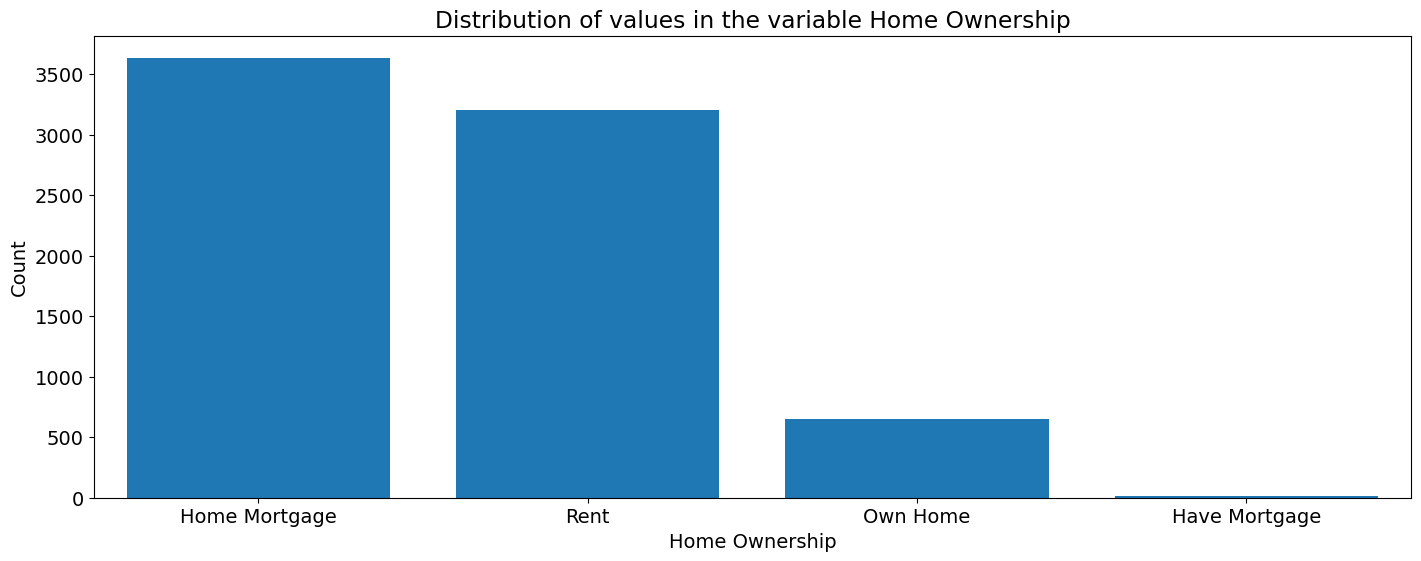

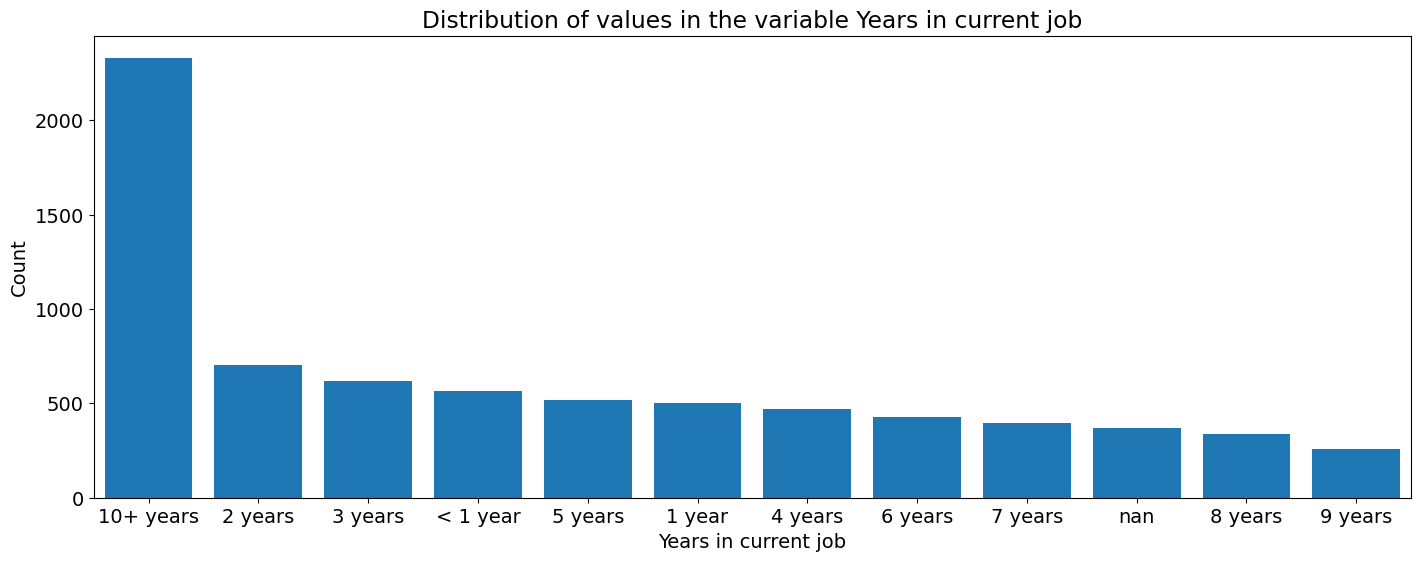

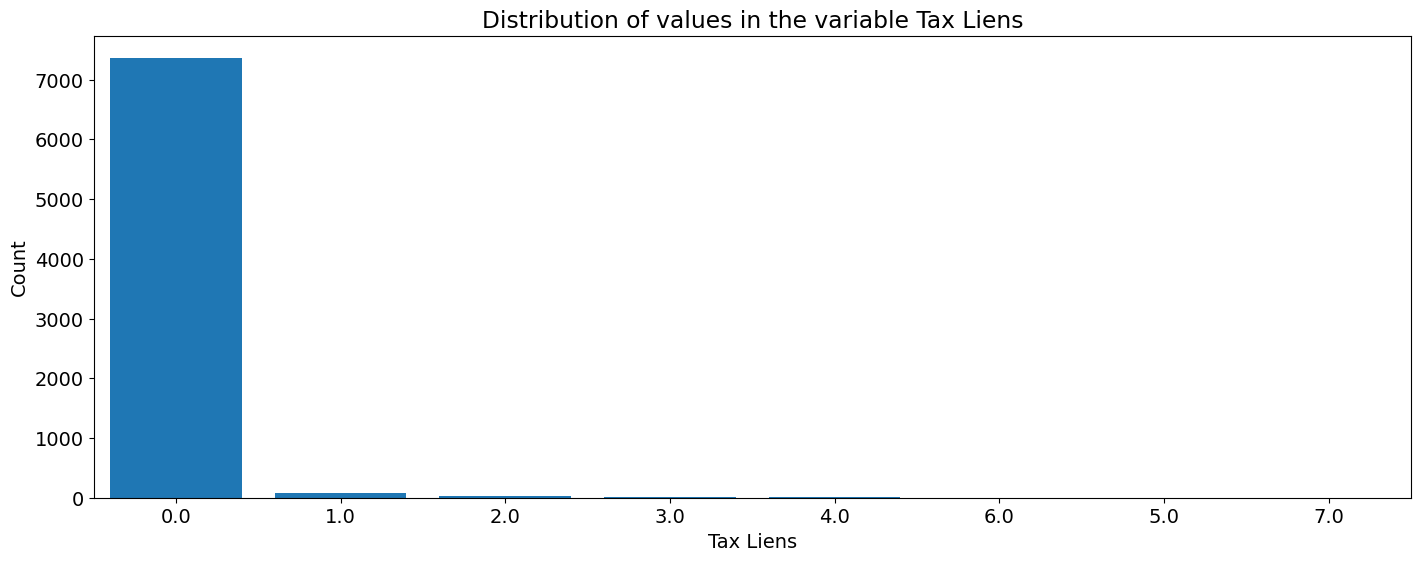

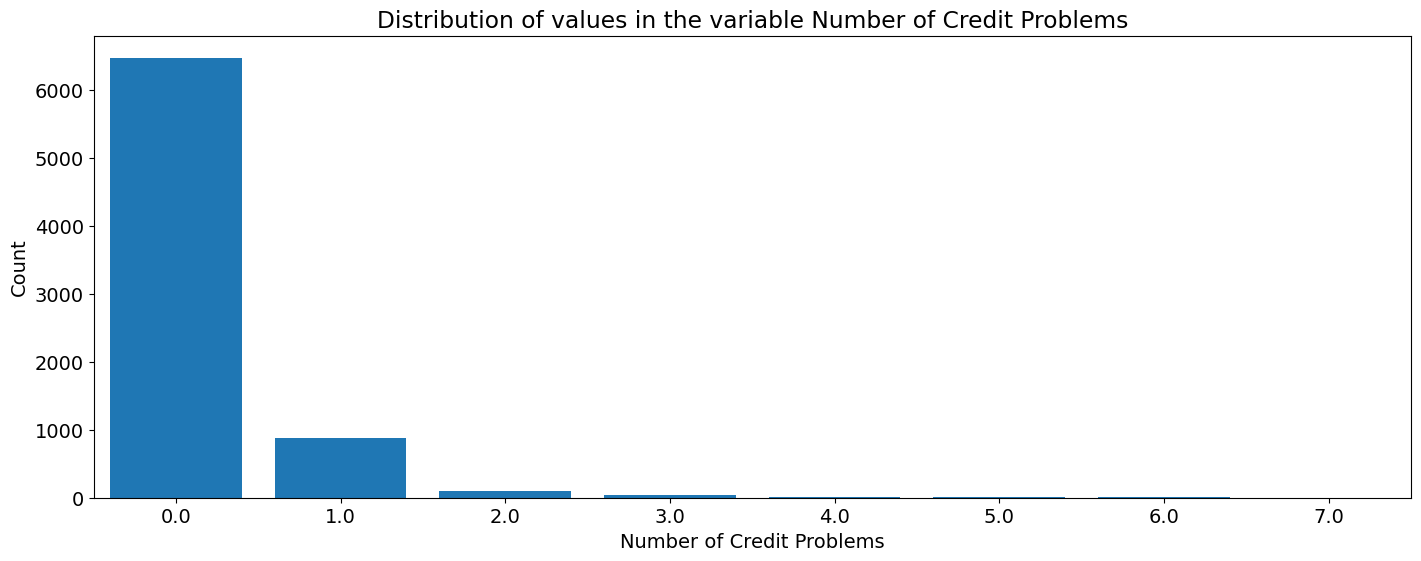

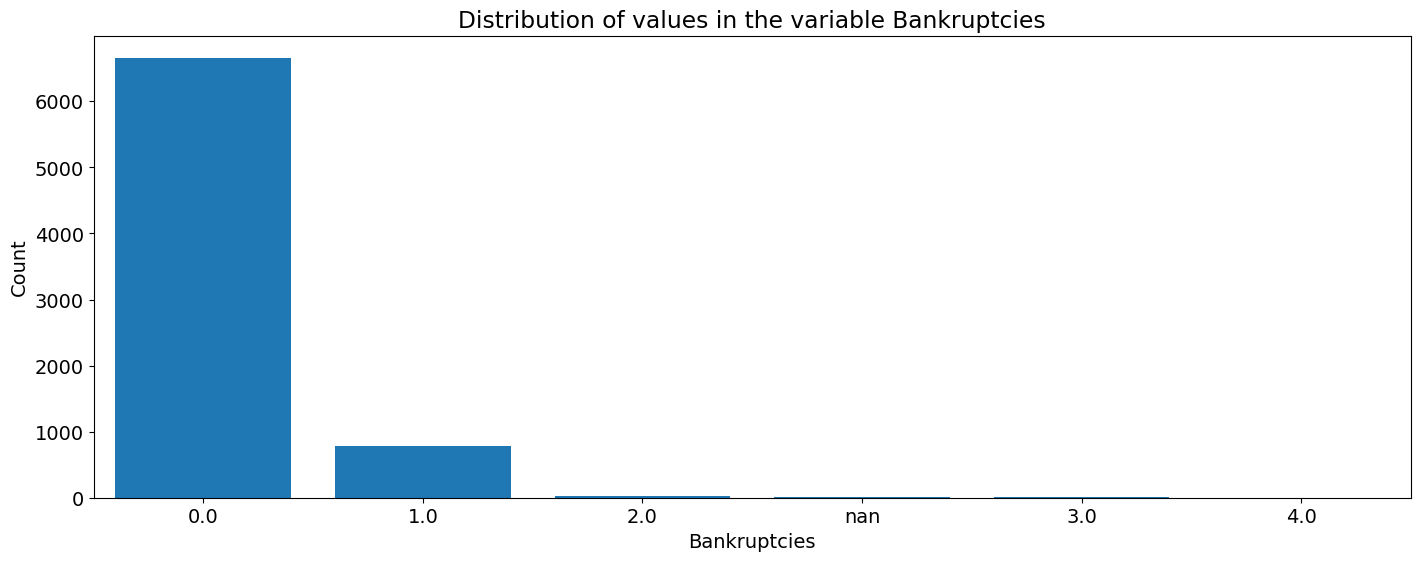

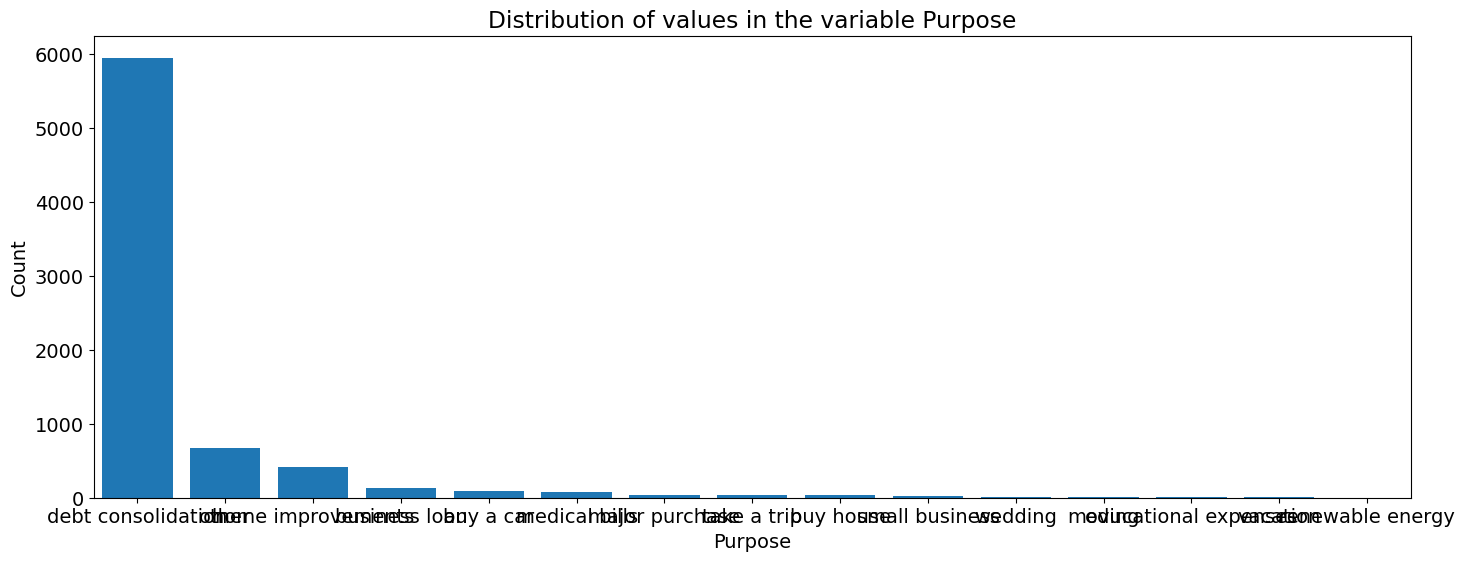

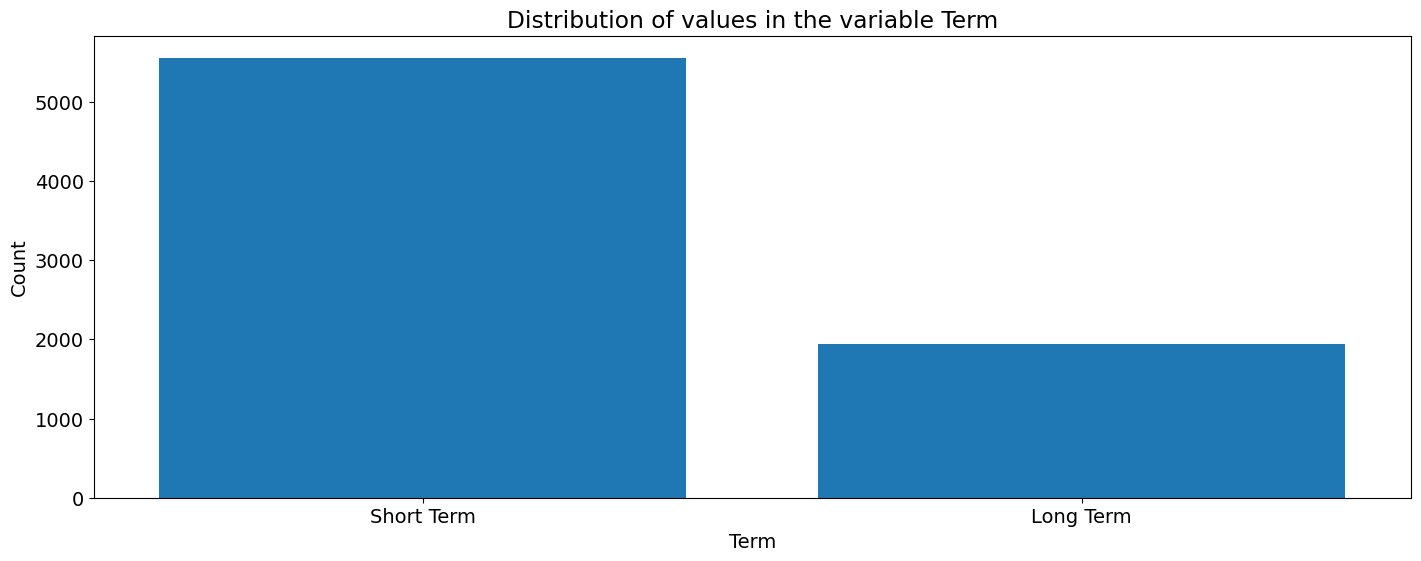

In [29]:
for cat in categorical_var:
    plt.figure(figsize = (17, 6))
    #plt.figure()
    sns.barplot(
            x = categorical_var[cat].value_counts().index,
            y = categorical_var[cat].value_counts(),
            saturation = 1).set(title = f"Distribution of values in the variable {cat}");
    plt.xlabel(cat)
    plt.ylabel('Count')

Вывод:
Видим, что во всех признаках доминирует какой-то один. 

### Обработка пропусков  и выбросов

**Числовые признаки**

In [30]:
missingValuesInfo(df_train)

,Total,Percent
Months since last delinquent,4081,54.41
Credit Score,1557,20.76
Annual Income,1557,20.76


Вывод: если мы заменим в Months since last delinquent пропуски медианой, то нормального распределения не получится.
Annual Income заменить пропуски медианой. Credit Score проверить на ошибку.

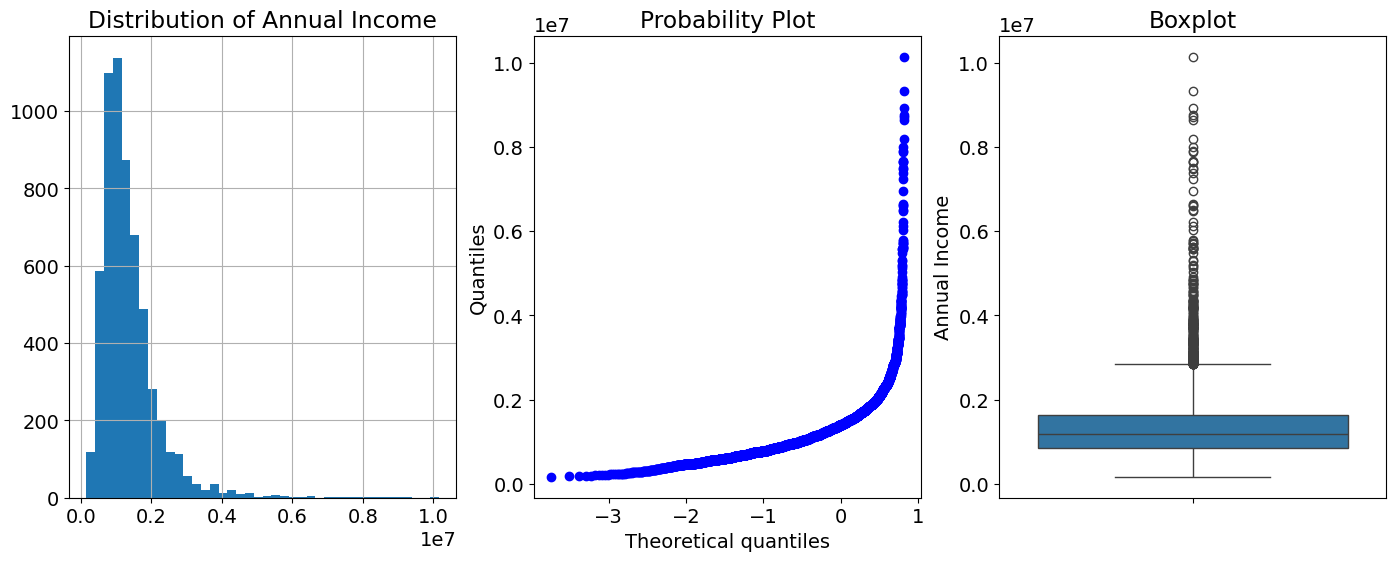

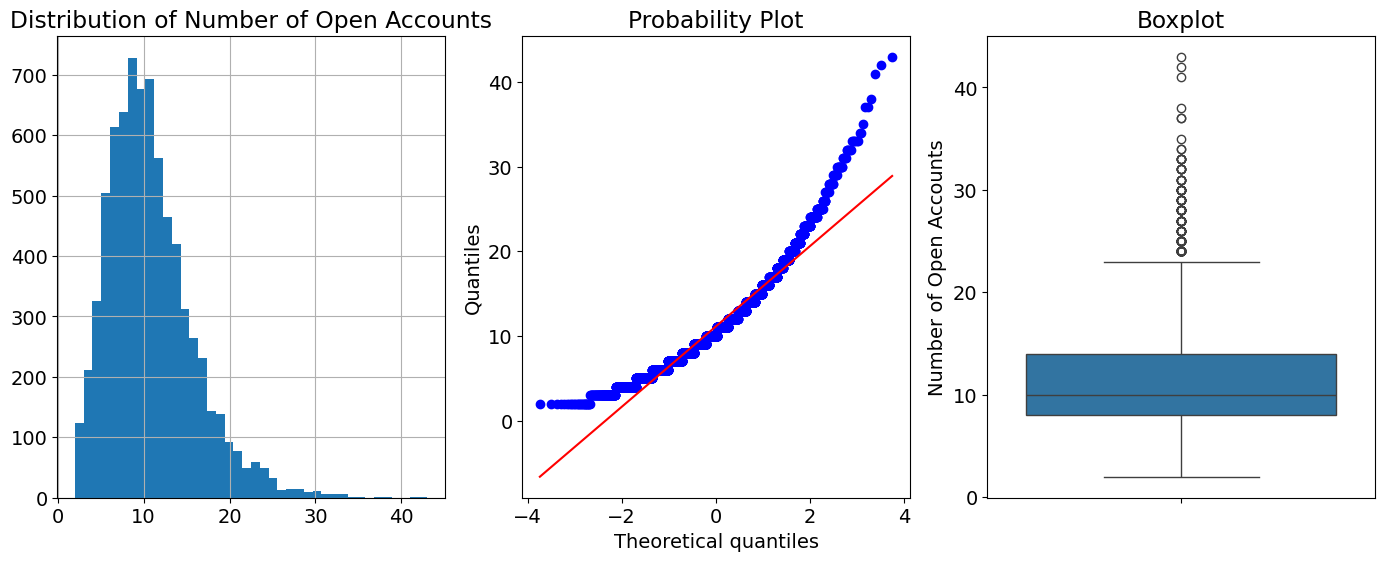

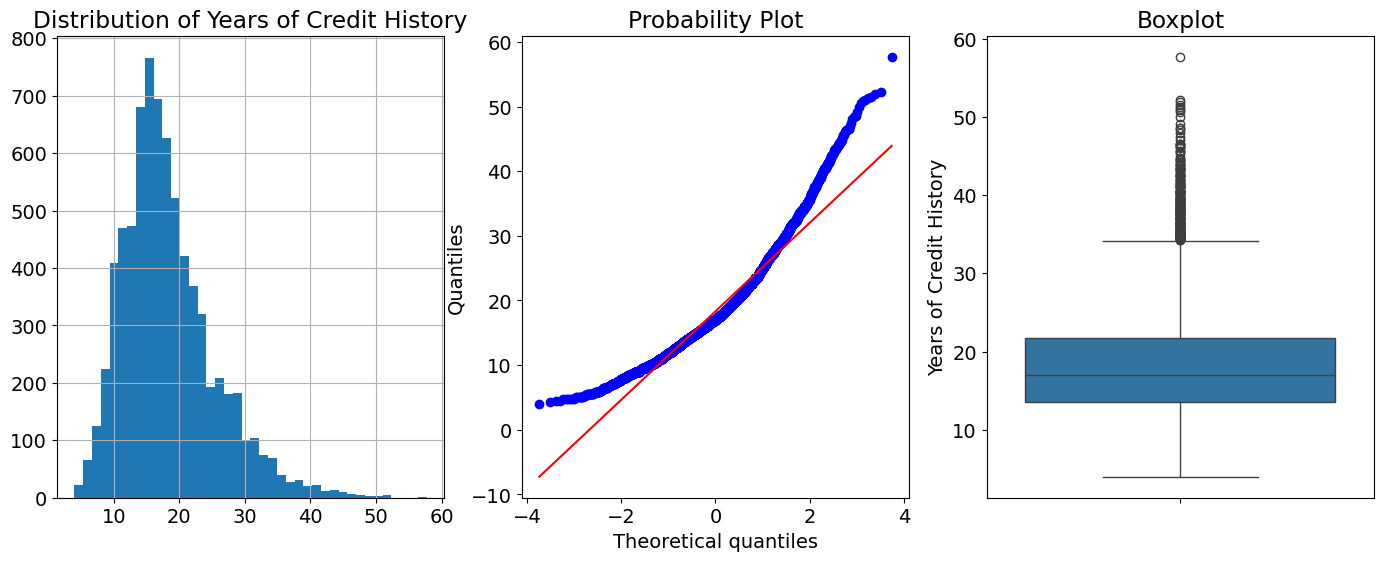

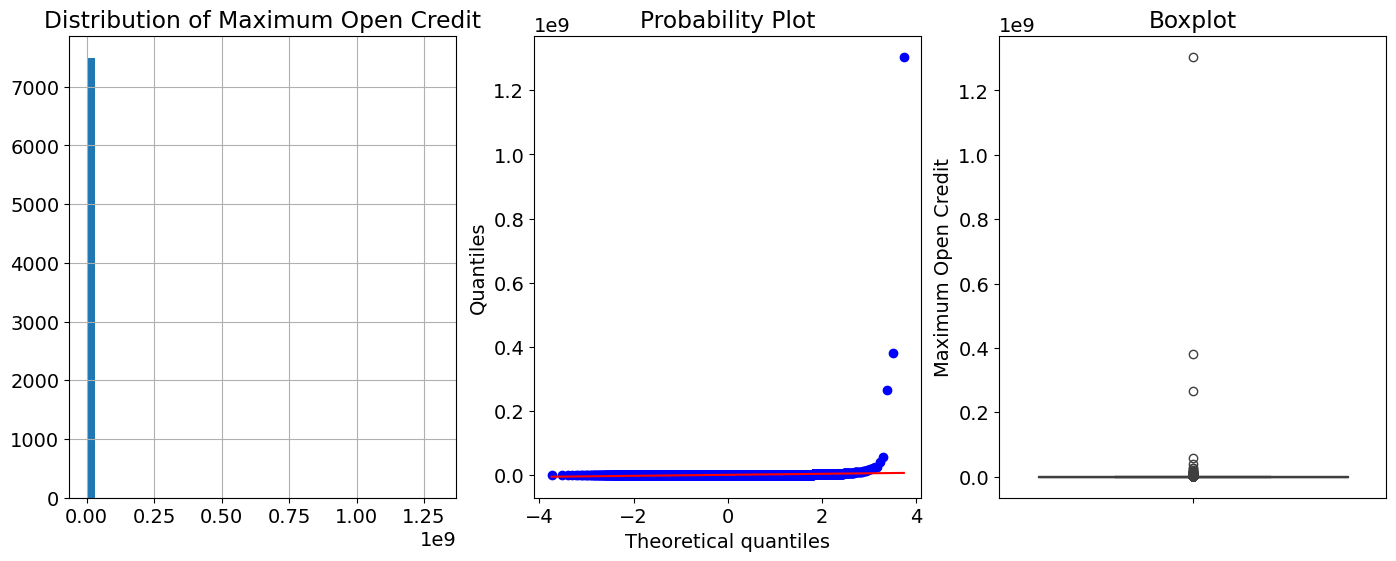

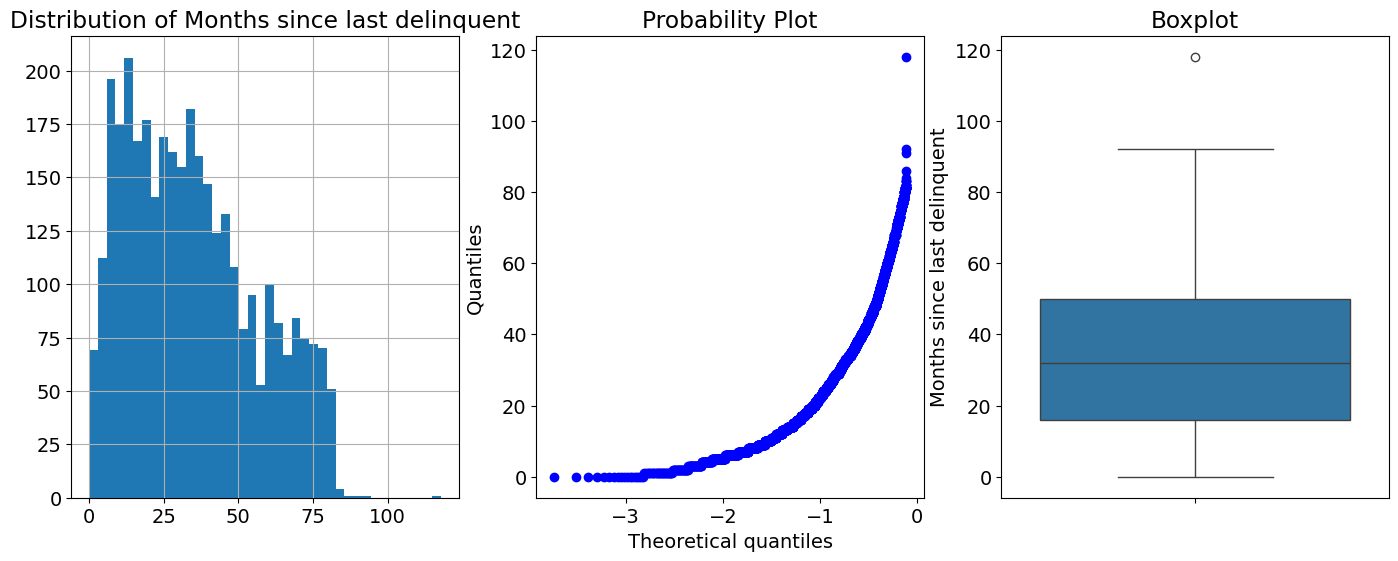

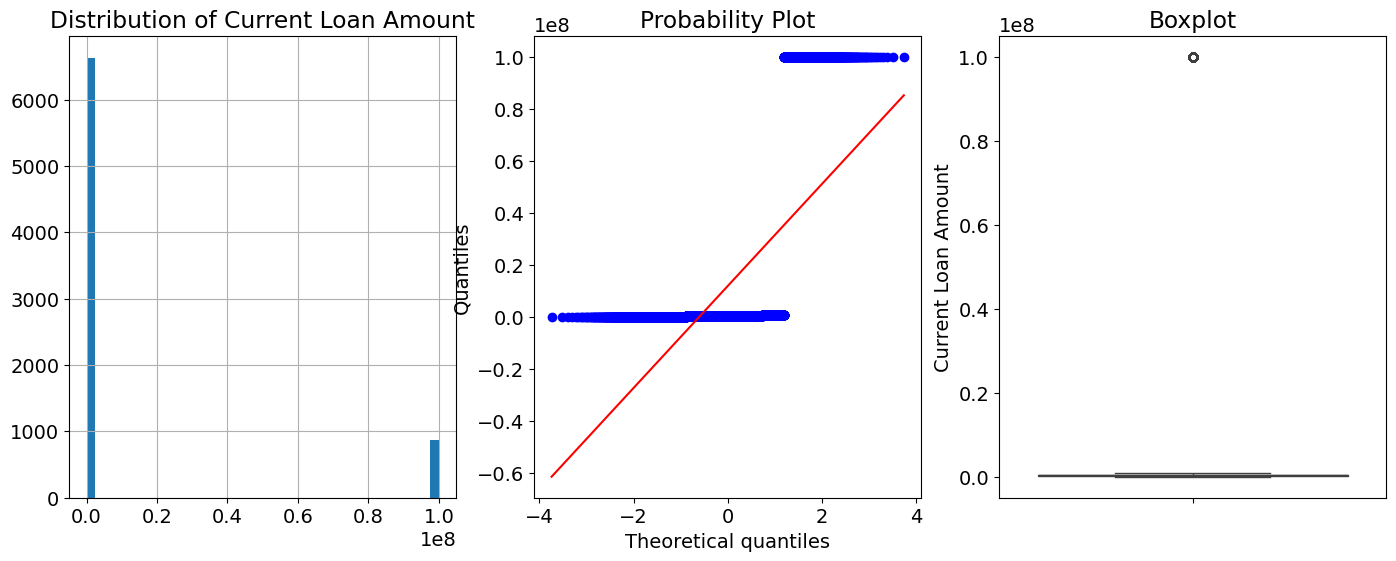

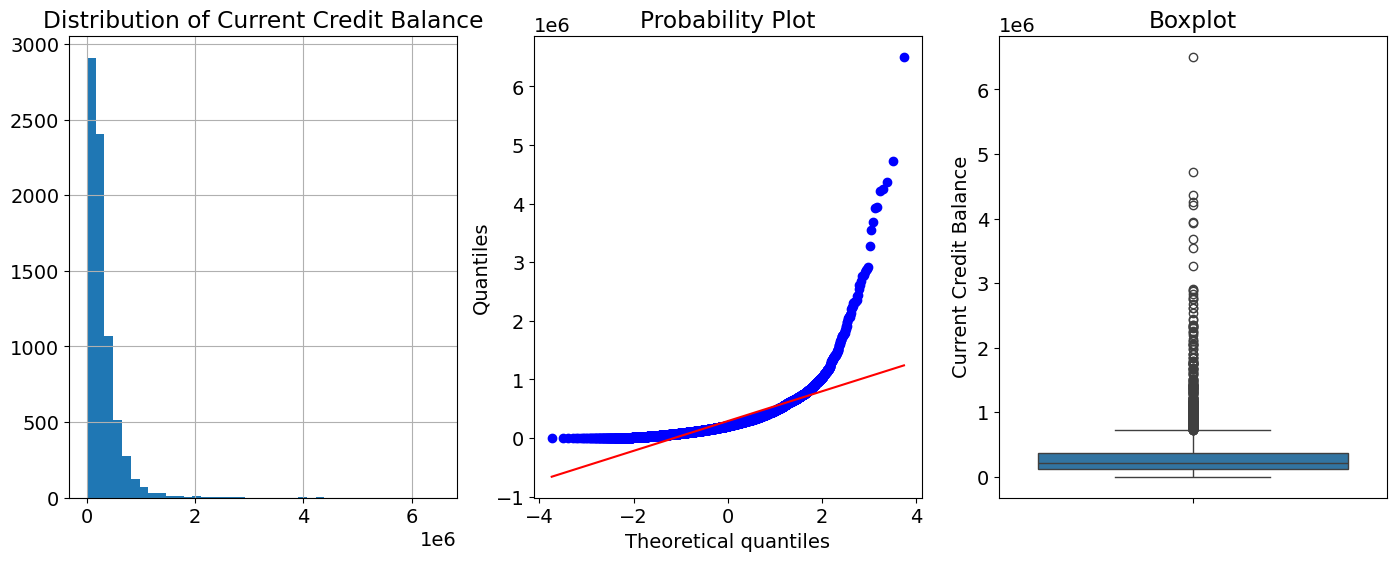

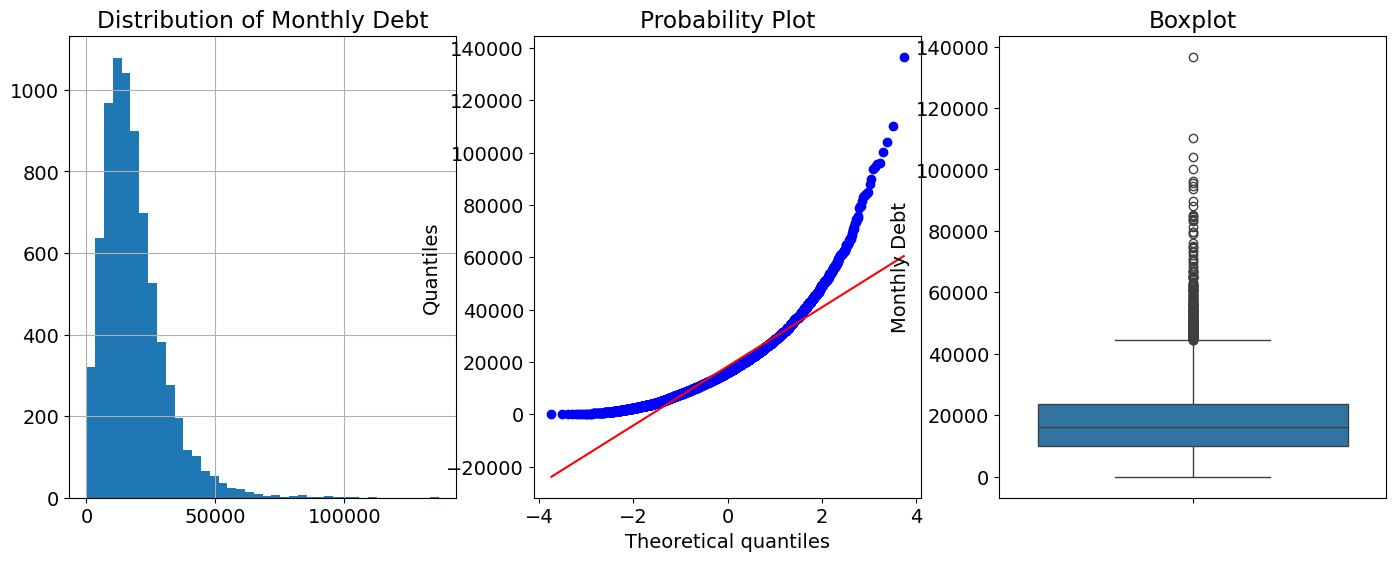

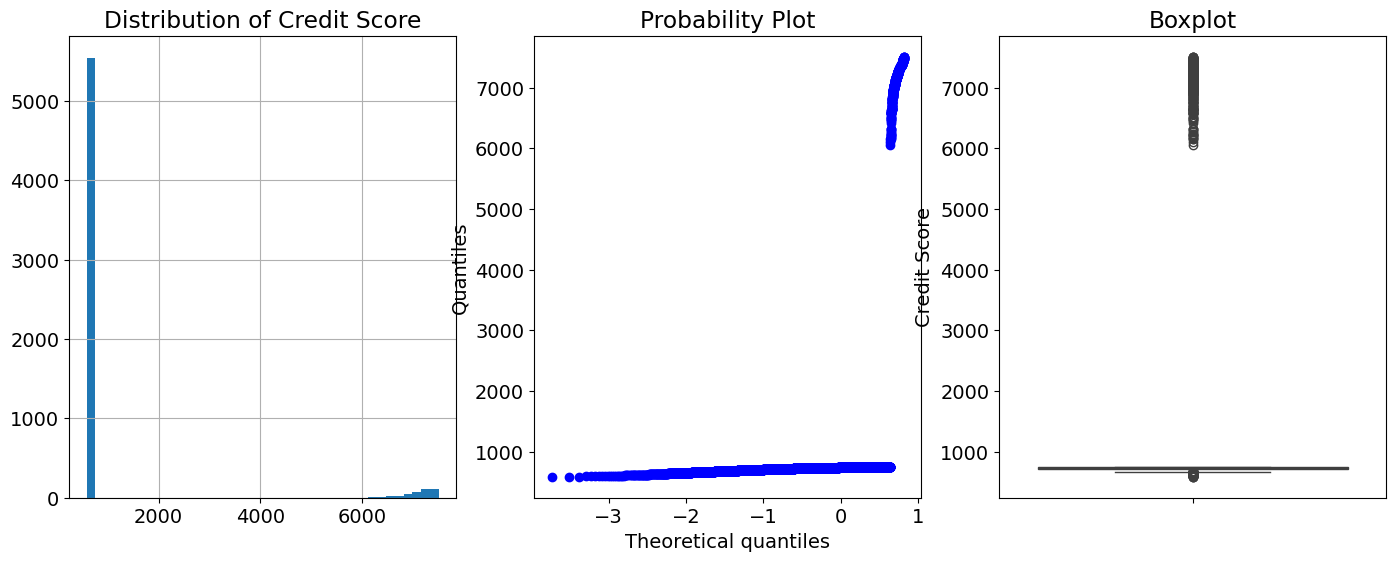

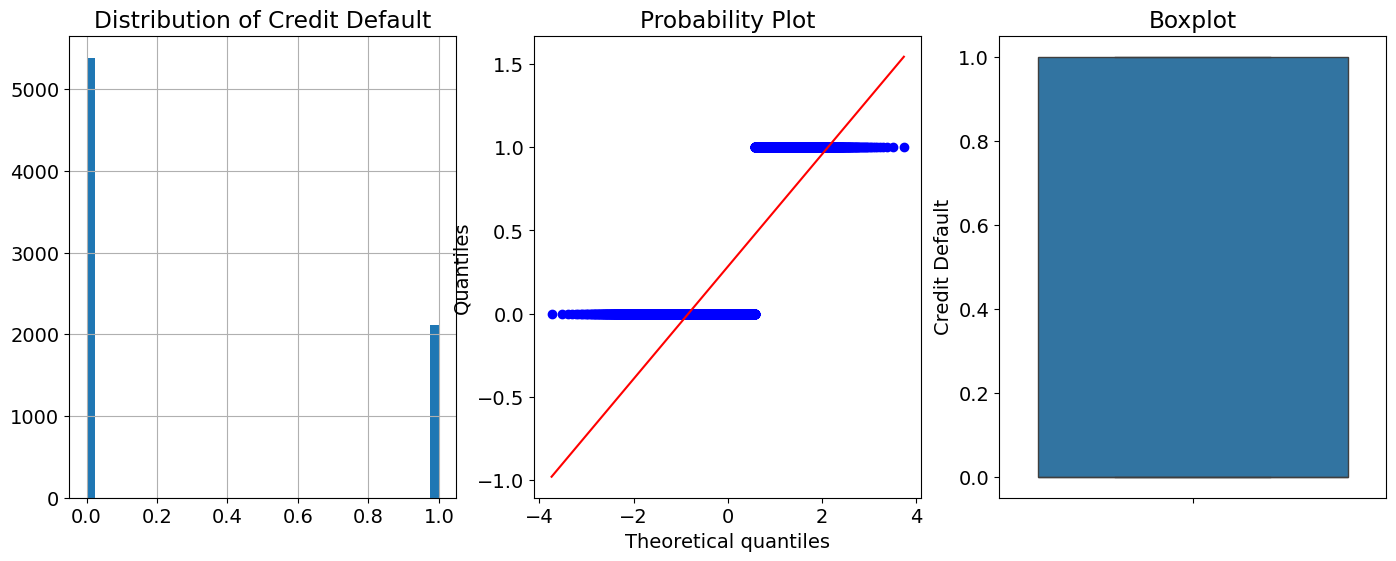

In [31]:
for var in numeric_var:
    num_plot(df_train, var)

Проверить:
1. Annual Income, Number of Open Accounts, Years of Credit History, Months since last delinquent: есть выбросы
2. Current Loan Amount, Credit Score,  Maximum Open Credit: посмотреть значения, не понятные графики 
3. Current Credit Balance: правосторонеее распределение.

#### Credit Score

In [32]:
df_train['Credit Score'].sort_values().unique()

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

In [33]:
df_train.loc[(df_train['Credit Score'] >= 6060)].shape

(400, 17)

Вывод: видим, что основные значения лежат в диапазоне 585-751 и только у 400 человек значения выше 6000, а должен быть до 1000.
От 0 до 400 - не дают кредит, от 401 до 600 - низкая вероятность одобрения и высокий %, от 601 до 800 - высокая вероятность одобрения, от 80 до 1000 - высокий рейтинг и низкий %. Скорей всего это ошибка и будем менять на 3 значное число (уберем 0 в конце). Также видим, что кредитный рейтинг находится в среднем диапазоне  и нет ни одного клиента у которого диапазон выше 800. 

In [34]:
df_train.loc[(df_train['Credit Score'] > 6000), 'Credit Score'] = df_train.loc[(df_train['Credit Score'] > 6000), 'Credit Score'] * 0.1

In [35]:
df_test.loc[(df_test['Credit Score'] > 6000), 'Credit Score'] = df_test.loc[(df_test['Credit Score'] > 6000), 'Credit Score'] * 0.1

In [36]:
df_train.loc[(df_train['Credit Score'] >= 6060)].shape

(0, 17)

In [37]:
df_train['Credit Score'].sort_values().unique()

array([585., 586., 588., 589., 590., 591., 593., 594., 597., 598., 599.,
       601., 602., 604., 606., 607., 608., 609., 610., 611., 612., 613.,
       614., 615., 616., 617., 618., 619., 620., 621., 622., 623., 624.,
       625., 626., 627., 628., 629., 630., 631., 632., 633., 634., 635.,
       636., 637., 638., 639., 640., 641., 642., 643., 644., 645., 646.,
       647., 648., 649., 650., 651., 652., 653., 654., 655., 656., 657.,
       658., 659., 660., 661., 662., 663., 664., 665., 666., 667., 668.,
       669., 670., 671., 672., 673., 674., 675., 676., 677., 678., 679.,
       680., 681., 682., 683., 684., 685., 686., 687., 688., 689., 690.,
       691., 692., 693., 694., 695., 696., 697., 698., 699., 700., 701.,
       702., 703., 704., 705., 706., 707., 708., 709., 710., 711., 712.,
       713., 714., 715., 716., 717., 718., 719., 720., 721., 722., 723.,
       724., 725., 726., 727., 728., 729., 730., 731., 732., 733., 734.,
       735., 736., 737., 738., 739., 740., 741., 74

In [38]:
# Меняем выбросы и пропуски на медиану
IQ_processing(df_train, list)

Monthly Debt {'IQ': 13750.5, 'low_border': -10558.25, 'high_border': 44443.75, 'count': 255, 'median': 16076.5}
count after procesing: 0
Credit Score {'IQ': 32.0, 'low_border': 660.0, 'high_border': 788.0, 'count': 271, 'median': 729.0}
count after procesing: 0
Current Credit Balance {'IQ': 246149.75, 'low_border': -254968.125, 'high_border': 729630.875, 'count': 440, 'median': 209323.0}
count after procesing: 0
Current Loan Amount {'IQ': 339713.0, 'low_border': -329400.5, 'high_border': 1029451.5, 'count': 870, 'median': 309573.0}
count after procesing: 0
Maximum Open Credit {'IQ': 514272.0, 'low_border': -492178.5, 'high_border': 1564909.5, 'count': 466, 'median': 478159.0}
count after procesing: 0
Months since last delinquent {'IQ': 34.0, 'low_border': -35.0, 'high_border': 101.0, 'count': 1, 'median': 32.0}
count after procesing: 0
Years of Credit History {'IQ': 8.3, 'low_border': 1.049999999999999, 'high_border': 34.25, 'count': 228, 'median': 17.0}
count after procesing: 0
Number

In [39]:
IQ_processing(df_test, list)

Monthly Debt {'IQ': 14121.25, 'low_border': -11157.125, 'high_border': 45327.875, 'count': 69, 'median': 16642.5}
count after procesing: 0
Credit Score {'IQ': 34.0, 'low_border': 655.0, 'high_border': 791.0, 'count': 63, 'median': 727.0}
count after procesing: 0
Current Credit Balance {'IQ': 256234.0, 'low_border': -274236.5, 'high_border': 750699.5, 'count': 125, 'median': 207385.0}
count after procesing: 0
Current Loan Amount {'IQ': 335456.0, 'low_border': -316057.5, 'high_border': 1025766.5, 'count': 297, 'median': 322366.0}
count after procesing: 0
Maximum Open Credit {'IQ': 524012.5, 'low_border': -507432.75, 'high_border': 1588617.25, 'count': 156, 'median': 478676.0}
count after procesing: 0
Months since last delinquent {'IQ': 34.0, 'low_border': -35.0, 'high_border': 101.0, 'count': 0, 'median': 30.0}
count after procesing: 0
Years of Credit History {'IQ': 8.700000000000001, 'low_border': 0.34999999999999964, 'high_border': 35.150000000000006, 'count': 70, 'median': 17.0}
count

In [40]:
df_train.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,"7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00"
mean,"1,217,460.58",10.74,17.64,"520,560.49",33.22,"309,088.03","232,773.78","16,945.79",725.24,0.28
std,"467,400.61",4.22,5.92,"322,288.22",14.67,"171,393.74","159,914.89","9,251.65",18.80,0.45
min,"164,597.00",2.00,4.00,0.00,0.00,"11,242.00",0.00,0.00,660.00,0.00
25%,"931,133.00",8.00,13.50,"279,229.50",32.00,"180,169.00","114,256.50","10,067.50",719.00,0.00
50%,"1,168,386.00",10.00,17.00,"478,153.50",32.00,"309,567.50","209,313.50","16,075.75",729.00,0.00
75%,"1,404,480.00",13.00,21.00,"694,479.50",32.00,"396,929.50","313,329.00","22,416.25",738.00,1.00
max,"2,833,185.00",23.00,34.20,"1,562,550.00",92.00,"789,030.00","729,448.00","44,382.00",751.00,1.00


**Категориальные признаки**

In [41]:
# заменяем nan 
df_train.loc[(df_train['Years in current job'] == 'nan'), 'Years in current job'] = '10+ years'
df_train.loc[(df_train['Bankruptcies'] == 'nan'), 'Bankruptcies'] = '0.0'
df_test.loc[(df_test['Years in current job'] == 'nan'), 'Years in current job'] = '10+ years'
df_test.loc[(df_test['Bankruptcies'] == 'nan'), 'Bankruptcies'] = '0.0'

In [42]:
df_train['Years in current job'].value_counts()

Years in current job
10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: count, dtype: int64

### Анализ целевой переменной

**Обзор распределения**

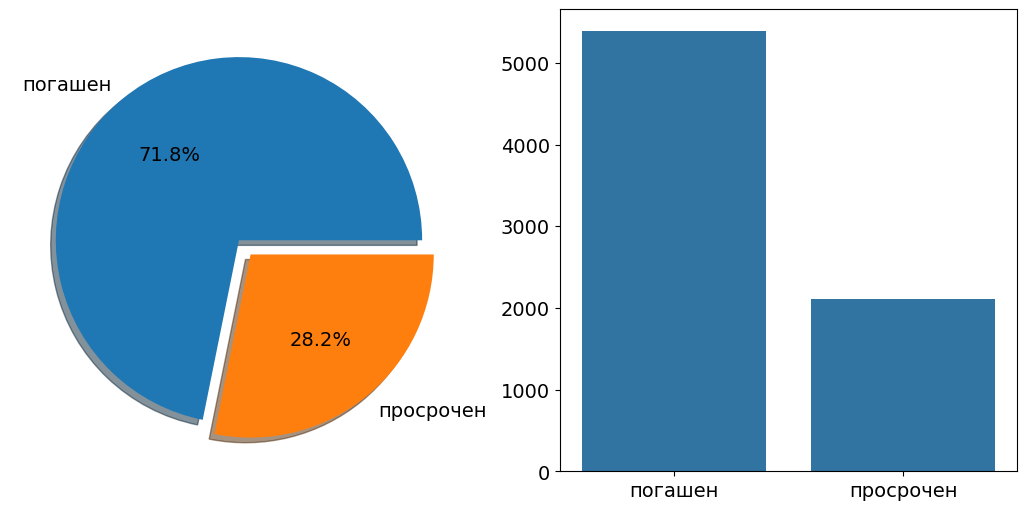

In [43]:
f,ax=plt.subplots(1,2,figsize=(13,6))
df_train['Credit Default'].replace({0:"погашен",1:"просрочен"}).value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x = df_train["Credit Default"].replace({0:"погашен",1:"просрочен"}) , ax = ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
plt.show()

Вывод: видим дисбаланс.

**Корреляция с базовыми признаками**

In [44]:
# corr_with_target = df_train.corr()["Credit Default"].sort_values(ascending=False)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
# plt.title('Correlation with target variable')
# plt.show()

In [45]:
# df_train.corr()["Credit Default"].sort_values(ascending=False)

Вывод: Видим, что корреляция очень слабая.

**Оценка признака "Credit Score" в разрезе целевой переменной**

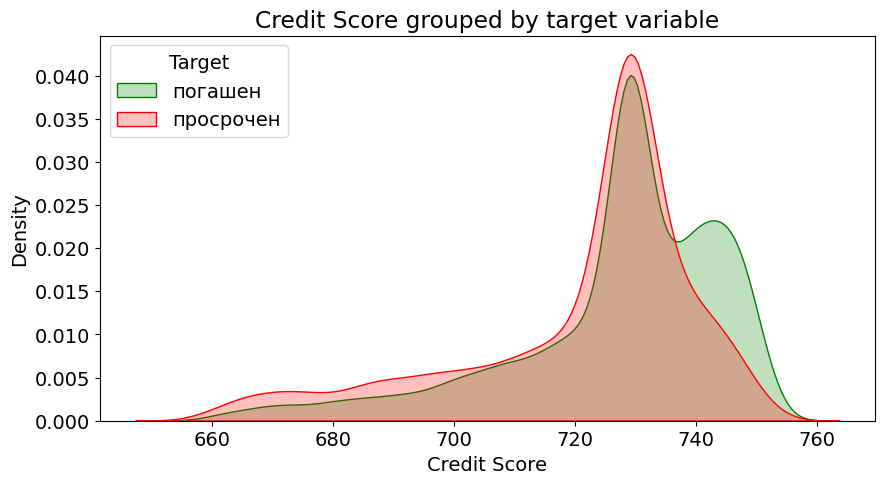

In [46]:
сredit_score_with_target = df_train[['Credit Score', 'Credit Default']]
сredit_score = сredit_score_with_target['Credit Score']
target_0 = сredit_score[сredit_score_with_target['Credit Default'] == 0]
target_1 = сredit_score[сredit_score_with_target['Credit Default'] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(target_0, shade=True, label='погашен', color='g')
sns.kdeplot(target_1, shade=True, label='просрочен', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper left')
plt.show()

Наблюдение

Видим, что разбиение "Credit Score" имеет различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком и целевой переменной, возможно, существует некоторая функциональная зависимость.

Гипотеза

Нулевая гипотеза: средние значения в двух независимых выборках равны.
Альтернативная гипотеза: средние значения в двух независимых выборках различаются.
Критерий: критерий Стьюдентa или аналоги.
Уровень значимости  𝛼 : 0.05.
Критическая область: двухсторонняя.
Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [47]:
shapiro(сredit_score)

ShapiroResult(statistic=0.8735153675079346, pvalue=0.0)

По полученному значению p-value, которое равно 0, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

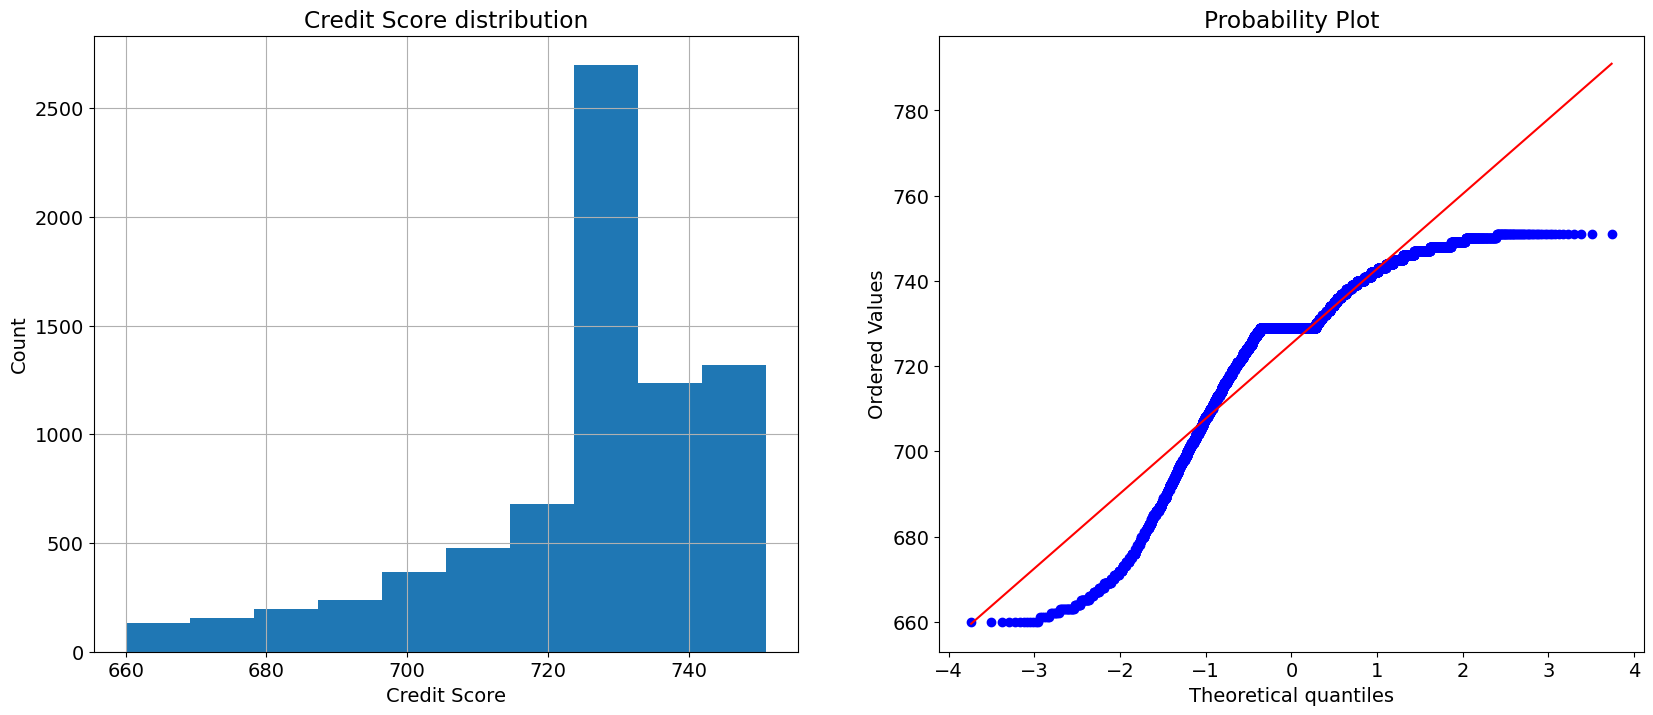

In [48]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
сredit_score.hist()

plt.subplot(122)
probplot(сredit_score, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [49]:
mannwhitneyu(target_0, target_1)

MannwhitneyuResult(statistic=6806250.0, pvalue=1.5417846281977303e-40)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

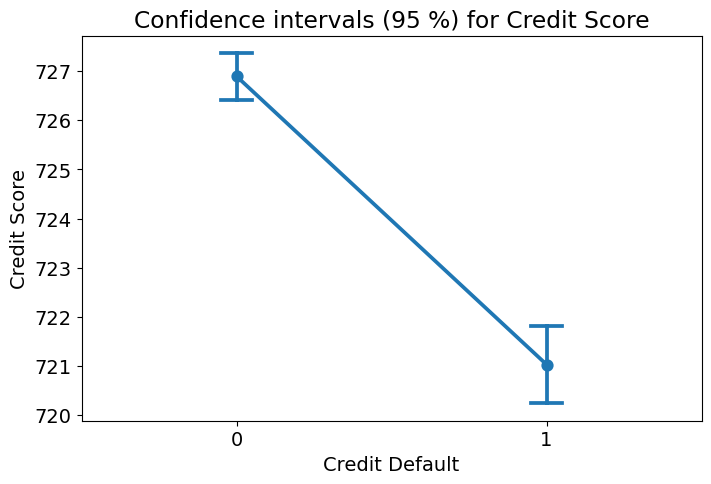

In [50]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Credit Default', y='Credit Score', data=сredit_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

Вывод: чем меньше рейтинг, тем выше процент просроченных платежей, чем выше рейтинг, тем выше процент погашения кредита.

**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

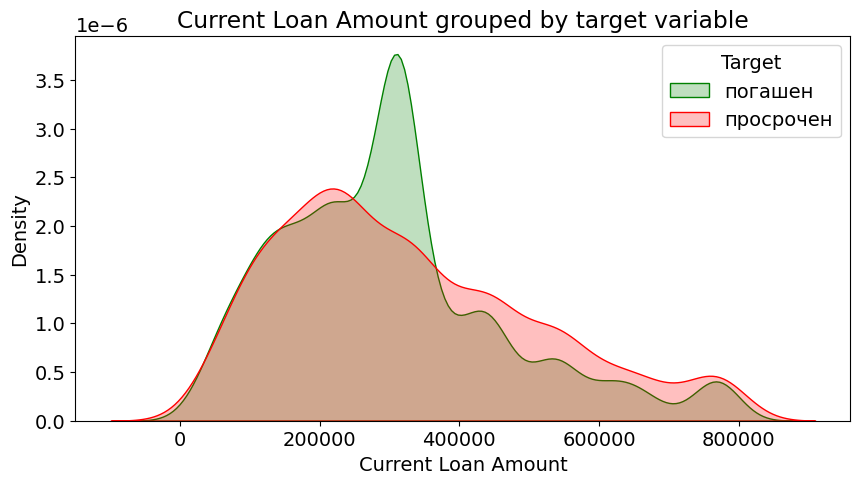

In [51]:
current_loan_amount_with_target = df_train[['Current Loan Amount', 'Credit Default']]
current_loan_amount = current_loan_amount_with_target['Current Loan Amount']
target_02 = current_loan_amount[current_loan_amount_with_target['Credit Default'] == 0]
target_12 = current_loan_amount[current_loan_amount_with_target['Credit Default'] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(target_02, shade=True, label='погашен', color='g')
sns.kdeplot(target_12, shade=True, label='просрочен', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.show()

Наблюдение

Видим, что разбиение "Current Loan Amount" имеет различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком и целевой переменной, возможно, существует некоторая функциональная зависимость.

Гипотеза

Нулевая гипотеза: средние значения в двух независимых выборках равны.
Альтернативная гипотеза: средние значения в двух независимых выборках различаются.
Критерий: критерий Стьюдентa или аналоги.
Уровень значимости  𝛼 : 0.05.
Критическая область: двухсторонняя.
Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [52]:
shapiro(current_loan_amount)

ShapiroResult(statistic=0.9422046542167664, pvalue=0.0)

По полученному значению p-value, которое равно 0, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

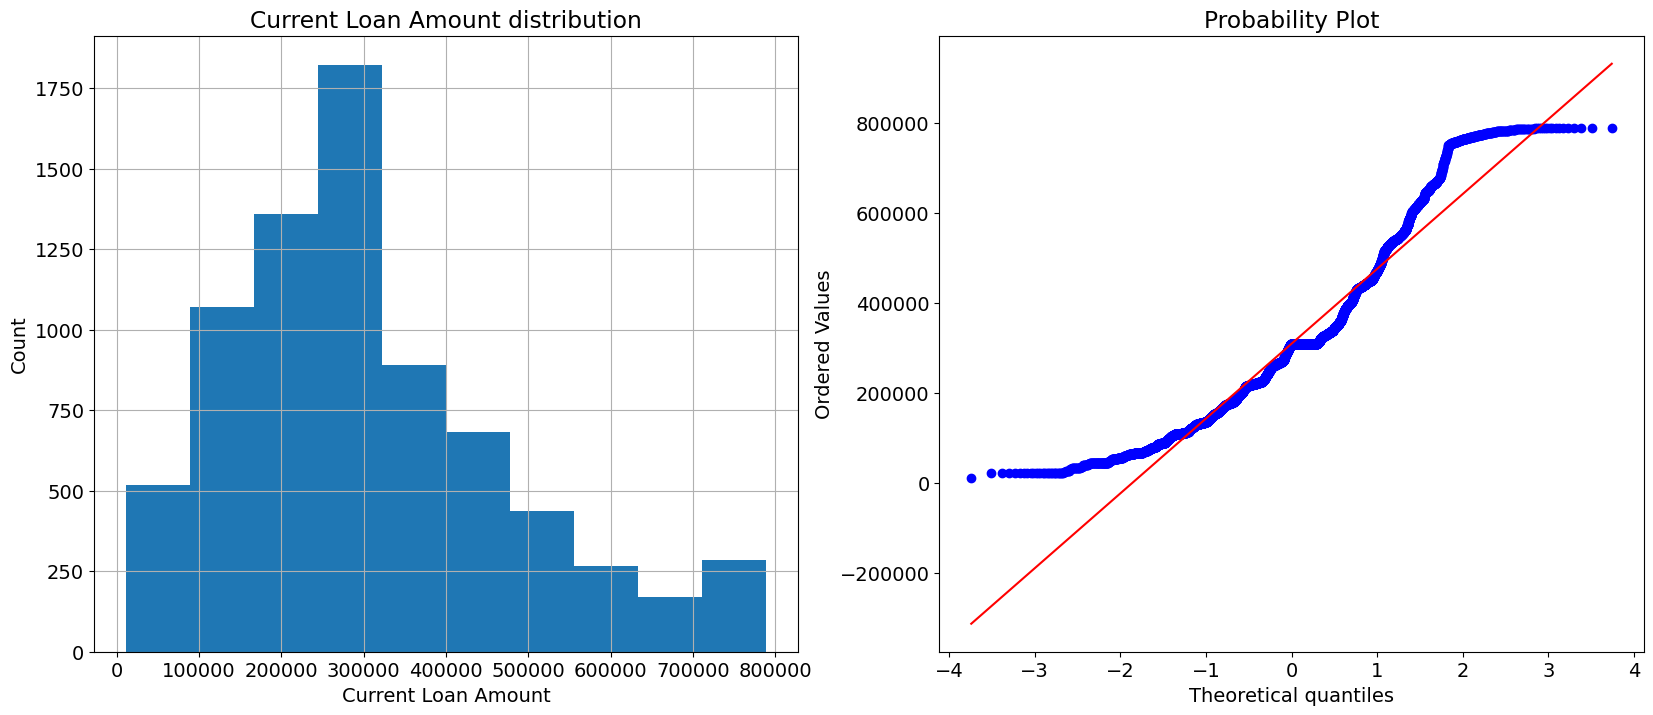

In [53]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
current_loan_amount.hist()

plt.subplot(122)
probplot(current_loan_amount, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [54]:
mannwhitneyu(target_02, target_12)

MannwhitneyuResult(statistic=5333033.0, pvalue=2.124323817669743e-05)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

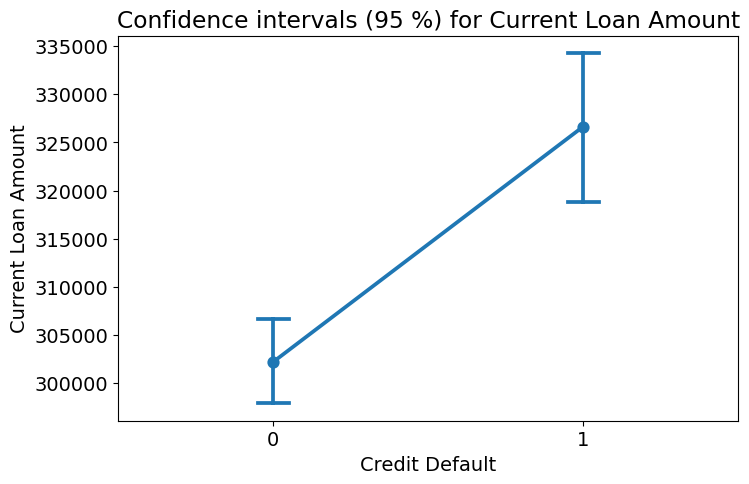

In [55]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Credit Default', y='Current Loan Amount', data=current_loan_amount_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Home Ownership" в разрезе целевой переменной**

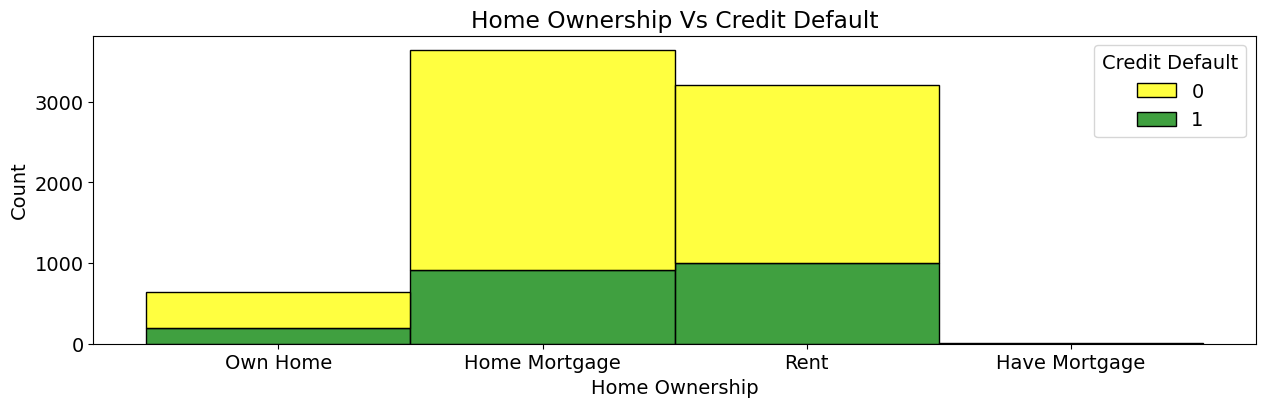

In [56]:
target_hist_plot("Home Ownership")

Наблюдение

Изучив получившийся график, видно, что значения Home Mortgage и Rent признака Home Ownership имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

Гипотеза

Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
Критерий: Хи-квадрат Пирсона
Уровень значимости  𝛼 : 0.05
Критическая область: двухсторонняя
Для проверки данной гипотезы необходимо подать наблюдаемые частоты  в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

Сформируем выборку и рассчитаем наблюдаемые частоты

In [57]:
df_train['index'] = df_train.index
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,index
0,Own Home,"482,087.00",10+ years,0.0,11.00,26.30,"685,960.00",1.0,32.00,1.0,debt consolidation,Short Term,"309,573.00","47,386.00","7,914.00",749.00,0,0
1,Own Home,"1,025,487.00",10+ years,0.0,15.00,15.30,"1,181,730.00",0.0,32.00,0.0,debt consolidation,Long Term,"264,968.00","394,972.00","18,373.00",737.00,1,1
2,Home Mortgage,"751,412.00",8 years,0.0,11.00,17.00,"1,182,434.00",0.0,32.00,0.0,debt consolidation,Short Term,"309,573.00","308,389.00","13,651.00",742.00,0,2
3,Own Home,"805,068.00",6 years,0.0,8.00,22.50,"147,400.00",1.0,32.00,1.0,debt consolidation,Short Term,"121,396.00","95,855.00","11,338.00",694.00,0,3
4,Rent,"776,264.00",8 years,0.0,13.00,13.60,"385,836.00",1.0,32.00,0.0,debt consolidation,Short Term,"125,840.00","93,309.00","7,180.00",719.00,0,4


In [58]:
home_ownership_target_s = df_train.loc[df_train['Home Ownership'].isin(['Home Mortgage', 'Rent']), ['index', 'Home Ownership', 'Credit Default']]

In [59]:
pd.pivot_table(values= 'index', index='Home Ownership', columns='Credit Default', aggfunc='count', data=df_train)

Credit Default,0,1
Home Ownership,,
Have Mortgage,10,2
Home Mortgage,2721,916
Own Home,455,192
Rent,2201,1003


In [60]:
table_1 = pd.pivot_table(values= 'index', index='Home Ownership', columns='Credit Default', aggfunc='count', data=home_ownership_target_s)
table_1

Credit Default,0,1
Home Ownership,,
Home Mortgage,2721,916
Rent,2201,1003


In [61]:
chi2, p, dof, expected = chi2_contingency(table_1)
print(f"{p:.10f}")

0.0000000221


Вывод: P-value получилось меньше выбранного уровня значимости, соответственно у нас есть основание для отвержения нулевой гипотезы и можно допустить, что категории Home Mortgage и Rent нельзя объединить в одну категорию.

**Оценка признака "Years in current job" в разрезе целевой переменной**

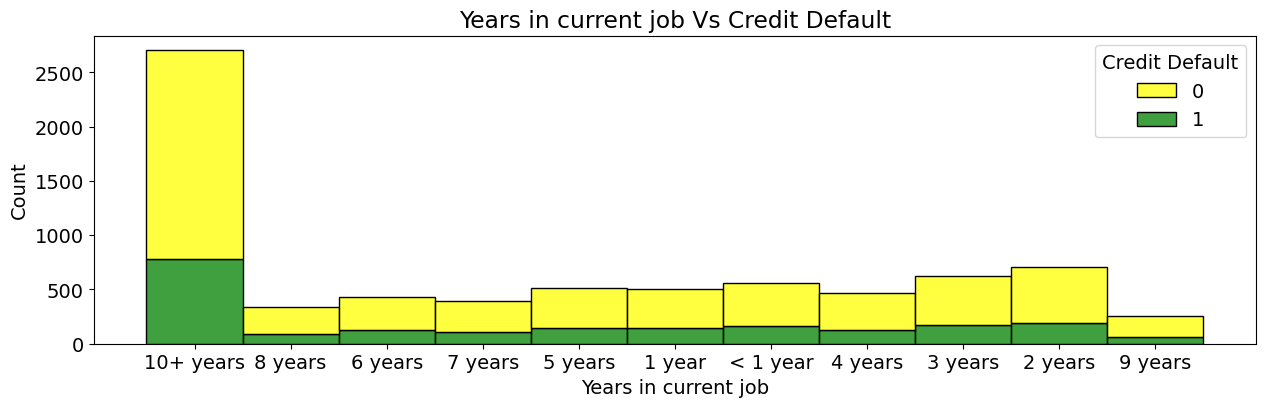

In [62]:
target_hist_plot("Years in current job")

In [63]:
years_current_target_s = df_train.loc[df_train['Years in current job'].isin(['1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year']), ['index', 'Years in current job', 'Credit Default']]

In [64]:
table_2 = pd.pivot_table(values= 'index', index='Years in current job', columns='Credit Default', aggfunc='count', data=years_current_target_s)
table_2

Credit Default,0,1
Years in current job,,
1 year,362,142
2 years,512,193
3 years,450,170
4 years,338,131
5 years,371,145
6 years,302,124
7 years,285,111
8 years,247,92
9 years,194,65


In [65]:
chi2, p, dof, expected = chi2_contingency(table_2)
p

0.9962062438103243

Вывод: P-value получилось выше выбранного уровня значимости, соответственно у нас нет основания для отвержения нулевой гипотезы и можно допустить, что категории '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year' можно объединить в одну категорию. Но тогда образуется дисбаланс классов. Предположим, что можно разбить данный признак на 3 класса: от 0 до 4 лет, от 5 до 9 лет и свыше 10 лет.

In [66]:
df_train['Years in current job'] = df_train['Years in current job'].replace({"< 1 year": '0-4 years', "1 year": '0-4 years', "2 years": '0-4 years', "3 years": '0-4 years', "4 years": '0-4 years'})
df_train['Years in current job'] = df_train['Years in current job'].replace({"5 years": '5-9 years', "6 years": '5-9 years', "7 years": '5-9 years', "8 years": '5-9 years', "9 years": '5-9 years'})
df_train['Years in current job'].value_counts()

Years in current job
0-4 years    2861
10+ years    2703
5-9 years    1936
Name: count, dtype: int64

In [67]:
df_test['Years in current job'] = df_test['Years in current job'].replace({"< 1 year": '0-4 years', "1 year": '0-4 years', "2 years": '0-4 years', "3 years": '0-4 years', "4 years": '0-4 years'})
df_test['Years in current job'] = df_test['Years in current job'].replace({"5 years": '5-9 years', "6 years": '5-9 years', "7 years": '5-9 years', "8 years": '5-9 years', "9 years": '5-9 years'})
df_test['Years in current job'].value_counts()

Years in current job
0-4 years    952
10+ years    896
5-9 years    652
Name: count, dtype: int64

In [68]:
years_current_target_s1 = df_train.loc[df_train['Years in current job'].isin(['0-4 years', '10+ years', '5-9 years']), ['index', 'Years in current job', 'Credit Default']]

In [69]:
table_21 = pd.pivot_table(values= 'index', index='Years in current job', columns='Credit Default', aggfunc='count', data=years_current_target_s1)
table_21

Credit Default,0,1
Years in current job,,
0-4 years,2066,795
10+ years,1922,781
5-9 years,1399,537


In [70]:
chi2, p, dof, expected = chi2_contingency(table_21)
p

0.5811434159419342

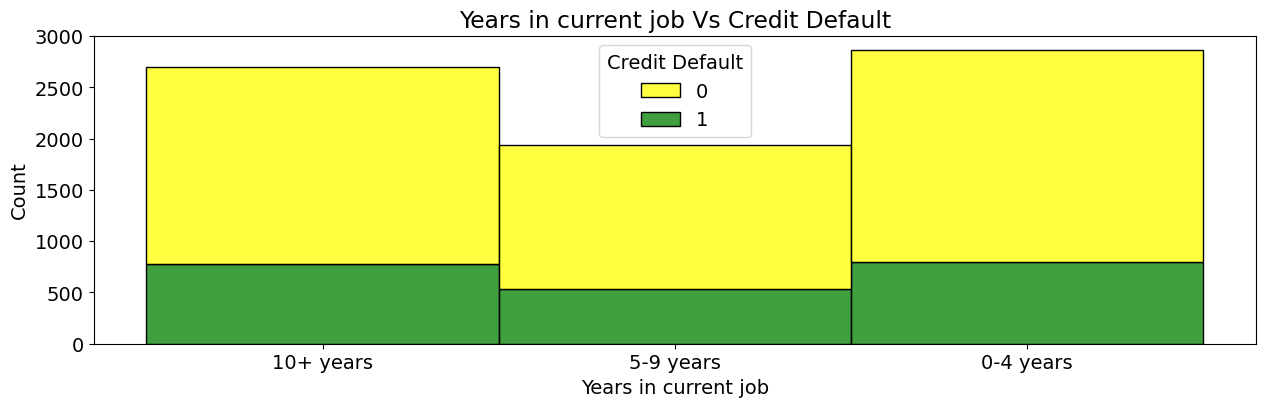

In [71]:
target_hist_plot("Years in current job")

In [72]:
df_train.drop(columns = ['index'] , inplace = True)

**Преобразуем категориальные признаки**

In [73]:
for cat_colname in df_train.select_dtypes(include='object').columns[:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [74]:
for cat_colname in df_test.select_dtypes(include='object').columns[:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [75]:
df_train.select_dtypes(include='object').columns[:]

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term'],
      dtype='object')

In [76]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_0-4 years',
       'Years in current job_10+ years', 'Years in current job_5-9 years',
       'Tax Liens_0.0', 'Tax Liens_1.0', 'Tax Liens_2.0', 'Tax Liens_3.0',
       'Tax Liens_4.0', 'Tax Liens_5.0', 'Tax Liens_6.0', 'Tax Liens_7.0',
       'Number of Credit Problems_0.0', 'Number of Credit Problems_1.0',
       'Number of Credit Problems_2.0', 'Number of Credit Problems_3.0',
       'Number of Credit Problems_4.0', 'Number of Credit Problems_5.0',
       '

**Корреляция с преобразованными категориальными признаками**

In [77]:
# corr_with_target = df_train.corr()["Credit Default"].sort_values(ascending=False)
# plt.figure(figsize=(8, 15))
# sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
# plt.title('Correlation with target variable')
# plt.show()

Вывод: видим слишком слабую корреляцию между признаком и таргетом.

### Стандартизация данных

Т.к. наши данные имеют разный масштаб, необходимо привести данные к нормальному виду. Для этого применим стандартизацию.

In [78]:
# вывод таргета, категориальных и числовых данных
target_name = ['Credit Default']
categorical_var = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
numeric_var = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Months since last delinquent',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_0-4 years',
       'Years in current job_10+ years', 'Years in current job_5-9 years',
       'Term_Long Term', 'Term_Short Term']

In [79]:
preproces(df_train)

In [80]:
preproces(df_test)

In [81]:
df_train.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_0-4 years,Years in current job_10+ years,Years in current job_5-9 years,Term_Long Term,Term_Short Term
count,"7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00"
mean,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.28,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.45,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.25,-2.07,-2.30,-1.62,-2.26,-1.74,-1.46,-1.83,-3.47,0.00,-0.04,-0.97,-0.31,-0.86,-0.79,-0.75,-0.59,-0.59,-1.69
25%,-0.61,-0.65,-0.70,-0.75,-0.08,-0.75,-0.74,-0.74,-0.33,0.00,-0.04,-0.97,-0.31,-0.86,-0.79,-0.75,-0.59,-0.59,-1.69
50%,-0.11,-0.18,-0.11,-0.13,-0.08,0.00,-0.15,-0.09,0.20,0.00,-0.04,-0.97,-0.31,-0.86,-0.79,-0.75,-0.59,-0.59,0.59
75%,0.40,0.53,0.57,0.54,-0.08,0.51,0.50,0.59,0.68,1.00,-0.04,1.03,-0.31,1.16,1.27,1.33,1.70,1.69,0.59
max,3.46,2.90,2.80,3.23,4.01,2.80,3.11,2.97,1.37,1.00,24.98,1.03,3.25,1.16,1.27,1.33,1.70,1.69,0.59


### Разбиение на train и test

In [82]:
X = df_train.drop(['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term'], axis=1)
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

Балансировка методом upsampling:

1. возьмём все данные с классом 1
2. продублируем его rat раз
3. присоединим к данным класса 0 продублированный класс 1 и перемещаем

In [83]:
df_train['Credit Default'].value_counts()

Credit Default
0    5387
1    2113
Name: count, dtype: int64

In [84]:
rat = len(df_train.loc[df_train['Credit Default']==0])//len(df_train.loc[df_train['Credit Default']==1])
df_1 = df_train.loc[df_train['Credit Default']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
train_n = pd.concat([df_train.loc[df_train['Credit Default']==0], df_1]).sample(frac=1)

In [85]:
train_n['Credit Default'].value_counts()

Credit Default
0    5387
1    4226
Name: count, dtype: int64

In [86]:
X =  train_n[train_n.columns.difference(['Credit Default'])].drop(['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term'], axis=1)
y = train_n['Credit Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [87]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_lr = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.77      0.70      4297
           1       0.60      0.44      0.51      3393

    accuracy                           0.62      7690
   macro avg       0.62      0.60      0.60      7690
weighted avg       0.62      0.62      0.61      7690

TEST

              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1090
           1       0.61      0.45      0.52       833

    accuracy                           0.64      1923
   macro avg       0.63      0.62      0.61      1923
weighted avg       0.63      0.64      0.63      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               857  233
1               462  371


**k ближайших соседей**

In [88]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_knn = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      4297
           1       0.73      0.69      0.71      3393

    accuracy                           0.75      7690
   macro avg       0.75      0.75      0.75      7690
weighted avg       0.75      0.75      0.75      7690

TEST

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      1090
           1       0.58      0.57      0.57       833

    accuracy                           0.63      1923
   macro avg       0.62      0.62      0.62      1923
weighted avg       0.63      0.63      0.63      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               740  350
1               358  475


**XGBoost**

In [89]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_xgb = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4297
           1       0.96      0.96      0.96      3393

    accuracy                           0.96      7690
   macro avg       0.96      0.96      0.96      7690
weighted avg       0.96      0.96      0.96      7690

TEST

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1090
           1       0.72      0.80      0.76       833

    accuracy                           0.78      1923
   macro avg       0.78      0.78      0.78      1923
weighted avg       0.79      0.78      0.78      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               832  258
1               163  670


**LightGBM**

In [90]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_lgbm = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3393, number of negative: 4297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 7690, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.441222 -> initscore=-0.236203
[LightGBM] [Info] Start training from score -0.236203
TRAIN

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4297
           1       0.89      0.87      0.88      3393

    accuracy                           0.89      7690
   macro avg       0.89      0.89      0.89      7690
weighted avg       0.89      0.89      0.89      7690

TEST

              precision  

**CatBoost**

In [91]:
#Приведение типов для модели CatBoost
for colname in categorical_var:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[categorical_var].dtypes

Home Ownership               category
Years in current job         category
Tax Liens                    category
Number of Credit Problems    category
Bankruptcies                 category
Purpose                      category
Term                         category
dtype: object

In [92]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_catb = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4297
           1       0.86      0.83      0.85      3393

    accuracy                           0.87      7690
   macro avg       0.87      0.86      0.86      7690
weighted avg       0.87      0.87      0.87      7690

TEST

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1090
           1       0.68      0.69      0.68       833

    accuracy                           0.72      1923
   macro avg       0.72      0.72      0.72      1923
weighted avg       0.72      0.72      0.72      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               820  270
1               262  571


**Support Vector Machines**

In [93]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

y_train_pred = svc_model.predict(X_train)
y_test_pred = svc_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_svc = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.80      0.74      4297
           1       0.68      0.52      0.59      3393

    accuracy                           0.68      7690
   macro avg       0.68      0.66      0.66      7690
weighted avg       0.68      0.68      0.67      7690

TEST

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1090
           1       0.61      0.48      0.54       833

    accuracy                           0.64      1923
   macro avg       0.63      0.62      0.62      1923
weighted avg       0.64      0.64      0.63      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               838  252
1               436  397


**Decision Tree**

In [94]:
decisiontree_model = DecisionTreeClassifier()
decisiontree_model.fit(X_train, y_train)

y_train_pred = decisiontree_model.predict(X_train)
y_test_pred = decisiontree_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_tree = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4297
           1       1.00      1.00      1.00      3393

    accuracy                           1.00      7690
   macro avg       1.00      1.00      1.00      7690
weighted avg       1.00      1.00      1.00      7690

TEST

              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1090
           1       0.70      0.88      0.78       833

    accuracy                           0.78      1923
   macro avg       0.79      0.79      0.78      1923
weighted avg       0.80      0.78      0.78      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               779  311
1               104  729


**Random Forest**

In [95]:
randomforest_model = RandomForestClassifier(random_state=21)
randomforest_model.fit(X_train, y_train)

y_train_pred = randomforest_model.predict(X_train)
y_test_pred = randomforest_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_forest = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4297
           1       1.00      1.00      1.00      3393

    accuracy                           1.00      7690
   macro avg       1.00      1.00      1.00      7690
weighted avg       1.00      1.00      1.00      7690

TEST

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1090
           1       0.81      0.86      0.84       833

    accuracy                           0.85      1923
   macro avg       0.85      0.85      0.85      1923
weighted avg       0.86      0.85      0.85      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               922  168
1               114  719


**Gradient Boosting Classifier**

In [96]:
gbk_model = GradientBoostingClassifier()
gbk_model.fit(X_train, y_train)

y_train_pred = gbk_model.predict(X_train)
y_test_pred = gbk_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_gbk = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.78      0.76      4297
           1       0.70      0.63      0.66      3393

    accuracy                           0.72      7690
   macro avg       0.71      0.71      0.71      7690
weighted avg       0.72      0.72      0.72      7690

TEST

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      1090
           1       0.65      0.59      0.62       833

    accuracy                           0.69      1923
   macro avg       0.68      0.68      0.68      1923
weighted avg       0.68      0.69      0.68      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               826  264
1               338  495


**Многослойный перцептрон, MLP**

In [98]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [101]:
mlp_model = Sequential()
mlp_model.add(Dense(64, input_dim=54, activation='relu'))  
mlp_model.add(Dense(32, activation='relu'))  
mlp_model.add(Dropout(0.3))  
mlp_model.add(Dense(1, activation='sigmoid'))  

mlp_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

mlp_model.summary()

history =  mlp_model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),  
                    epochs=250,  
                    batch_size=16,  
                    verbose=1)  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                3520      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
481/481 [==============================] - 5s 4ms/step - loss: 0.6645 - accuracy: 0.5996 - val_loss: 0.6442 - val_accuracy: 0.6297
Epoch 2/250
481/481 [====================

481/481 [==============================] - 2s 3ms/step - loss: 0.4614 - accuracy: 0.7662 - val_loss: 0.6342 - val_accuracy: 0.6734
Epoch 52/250
481/481 [==============================] - 2s 3ms/step - loss: 0.4638 - accuracy: 0.7598 - val_loss: 0.6332 - val_accuracy: 0.6713
Epoch 53/250
481/481 [==============================] - 2s 3ms/step - loss: 0.4556 - accuracy: 0.7638 - val_loss: 0.6387 - val_accuracy: 0.6734
Epoch 54/250
481/481 [==============================] - 2s 3ms/step - loss: 0.4537 - accuracy: 0.7688 - val_loss: 0.6418 - val_accuracy: 0.6812
Epoch 55/250
481/481 [==============================] - 2s 3ms/step - loss: 0.4582 - accuracy: 0.7620 - val_loss: 0.6469 - val_accuracy: 0.6750
Epoch 56/250
481/481 [==============================] - 2s 3ms/step - loss: 0.4505 - accuracy: 0.7732 - val_loss: 0.6432 - val_accuracy: 0.6724
Epoch 57/250
481/481 [==============================] - 2s 3ms/step - loss: 0.4485 - accuracy: 0.7728 - val_loss: 0.6417 - val_accuracy: 0.6755
Epoch

Epoch 108/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3742 - accuracy: 0.8057 - val_loss: 0.6936 - val_accuracy: 0.7025
Epoch 109/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3729 - accuracy: 0.8074 - val_loss: 0.7239 - val_accuracy: 0.7046
Epoch 110/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3742 - accuracy: 0.8031 - val_loss: 0.7136 - val_accuracy: 0.7067
Epoch 111/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3749 - accuracy: 0.8051 - val_loss: 0.7331 - val_accuracy: 0.7025
Epoch 112/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3707 - accuracy: 0.8104 - val_loss: 0.7391 - val_accuracy: 0.6994
Epoch 113/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3699 - accuracy: 0.8078 - val_loss: 0.7177 - val_accuracy: 0.7025
Epoch 114/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3743 - accuracy: 0.8013 - val_loss: 0.7316 - val_ac

481/481 [==============================] - 2s 3ms/step - loss: 0.3382 - accuracy: 0.8217 - val_loss: 0.7799 - val_accuracy: 0.7119
Epoch 165/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3338 - accuracy: 0.8235 - val_loss: 0.7519 - val_accuracy: 0.7228
Epoch 166/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3393 - accuracy: 0.8163 - val_loss: 0.7885 - val_accuracy: 0.7223
Epoch 167/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3416 - accuracy: 0.8168 - val_loss: 0.7830 - val_accuracy: 0.7207
Epoch 168/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3307 - accuracy: 0.8211 - val_loss: 0.8290 - val_accuracy: 0.7077
Epoch 169/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3372 - accuracy: 0.8177 - val_loss: 0.7799 - val_accuracy: 0.7213
Epoch 170/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3328 - accuracy: 0.8205 - val_loss: 0.7955 - val_accuracy: 0.7161

481/481 [==============================] - 2s 3ms/step - loss: 0.3140 - accuracy: 0.8277 - val_loss: 0.9063 - val_accuracy: 0.7343
Epoch 221/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3083 - accuracy: 0.8289 - val_loss: 0.9262 - val_accuracy: 0.7233
Epoch 222/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3121 - accuracy: 0.8274 - val_loss: 0.9147 - val_accuracy: 0.7306
Epoch 223/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3060 - accuracy: 0.8293 - val_loss: 0.9107 - val_accuracy: 0.7322
Epoch 224/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3131 - accuracy: 0.8295 - val_loss: 0.9201 - val_accuracy: 0.7207
Epoch 225/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3178 - accuracy: 0.8281 - val_loss: 0.8669 - val_accuracy: 0.7374
Epoch 226/250
481/481 [==============================] - 2s 3ms/step - loss: 0.3116 - accuracy: 0.8311 - val_loss: 0.9128 - val_accuracy: 0.7311

In [104]:
from sklearn.metrics import classification_report, f1_score

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

y_train_pred = (y_train_pred > 0.5).astype(int)
y_test_pred = (y_test_pred > 0.5).astype(int)

def get_classification_report(y_train, y_train_pred, y_test, y_test_pred):
    print("Classification Report for Training Set:")
    print(classification_report(y_train, y_train_pred))
    print("\nClassification Report for Test Set:")
    print(classification_report(y_test, y_test_pred))

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
f1_score_mlp = np.round(f1_score(y_test, y_test_pred, average=None) * 100, decimals = 2)

61/61 [==============================] - 0s 945us/step
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4297
           1       0.93      0.81      0.87      3393

    accuracy                           0.89      7690
   macro avg       0.90      0.88      0.89      7690
weighted avg       0.89      0.89      0.89      7690


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1090
           1       0.68      0.69      0.69       833

    accuracy                           0.73      1923
   macro avg       0.72      0.72      0.72      1923
weighted avg       0.73      0.73      0.73      1923



In [ ]:
# print(f"Length of y_train: {len(y_train)}, Length of y_train_pred: {len(y_train_pred)}")
# print(f"Length of y_test: {len(y_test)}, Length of y_test_pred: {len(y_test_pred)}")

In [ ]:
# y_train = y_train.ravel().astype(int)
# y_test = y_test.ravel().astype(int)

In [ ]:
# y_train_pred = y_train_pred.flatten().astype(int)
# y_test_pred = y_test_pred.flatten().astype(int)

In [105]:
models = pd.DataFrame({
    'Model': ['Gradient Boosting Classifier','Random Forest', 'Decision Tree', 'Support Vector Machines', 'CatBoost', 'LightGBM', 'XGBoost', 'KNN', 'Logistic Regression', 'Многослойный перцептрон'],
    'Score_0': [f1_score_gbk[0], f1_score_forest[0], f1_score_tree[0], f1_score_svc[0],  f1_score_catb[0], f1_score_lgbm[0], f1_score_xgb[0], f1_score_knn[0], f1_score_lr[0], f1_score_mlp[0]],
    'Score_1': [f1_score_gbk[1], f1_score_forest[1], f1_score_tree[1], f1_score_svc[1],  f1_score_catb[1], f1_score_lgbm[1], f1_score_xgb[1], f1_score_knn[1], f1_score_lr[1], f1_score_mlp[1]]})
models.sort_values(by='Score_1', ascending=False)

,Model,Score_0,Score_1
1,Random Forest,86.74,83.60
2,Decision Tree,78.97,77.84
6,XGBoost,79.81,76.09
9,Многослойный персептрон,75.84,68.62
4,CatBoost,75.51,68.22
5,LightGBM,75.17,67.55
0,Gradient Boosting Classifier,73.29,62.19
7,KNN,67.64,57.30
3,Support Vector Machines,70.90,53.58
8,Logistic Regression,71.15,51.64


### Выбор лучшей модели и подбор гиперпараметров

In [106]:
final_model = RandomForestClassifier(random_state=21)

**Подбор гиперпараметров**

In [107]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500], 
          'max_depth':[3, 5, 7, 10, 15], 
          'max_features': [5, 10, 15, 20, 25, 30, 40, 50]}

In [108]:
cv=KFold(n_splits=5, random_state=21, shuffle=True)

In [109]:
%time

res = RandomizedSearchCV(final_model, params, scoring='f1', cv=cv, n_jobs=-1)
res.fit(X, y)

CPU times: total: 0 ns
Wall time: 0 ns


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=RandomForestClassifier(random_state=21), n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 10, 15],
                                        'max_features': [5, 10, 15, 20, 25, 30,
                                                         40, 50],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [110]:
res.best_params_

{'n_estimators': 700, 'max_features': 25, 'max_depth': 15}

**Обучение и оценка финальной модели**

При установки параметров res.best_params_ F1-score упал на тестовой выборке, поэтому оставляю первоначальный вариант.

In [111]:
final_model = RandomForestClassifier(random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4297
           1       1.00      1.00      1.00      3393

    accuracy                           1.00      7690
   macro avg       1.00      1.00      1.00      7690
weighted avg       1.00      1.00      1.00      7690


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1090
           1       0.81      0.86      0.84       833

    accuracy                           0.85      1923
   macro avg       0.85      0.85      0.85      1923
weighted avg       0.86      0.85      0.85      1923



### Подбор оптимального размера выборки, кривая обучения

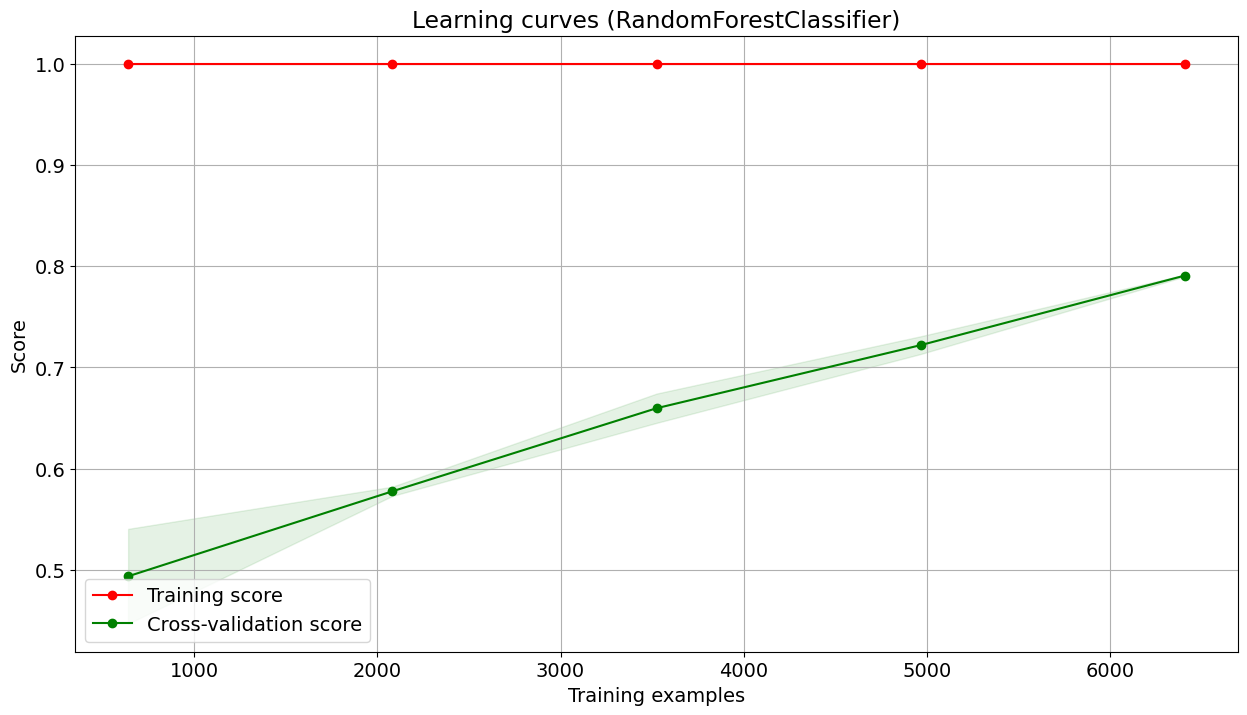

In [112]:
show_learning_curve_plot(randomforest_model, X, y)

Видим, что чем больше выборка тем выше  score.

### Выбор порога вероятности для определения класса

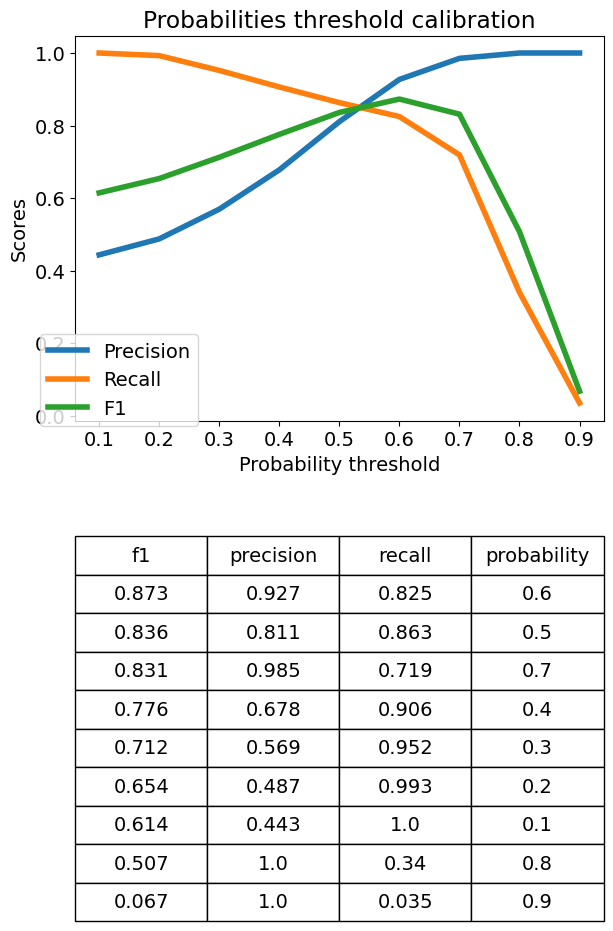

In [113]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Видим, что порог равен 0,5.В RandomForest порог по умолчанию 0,5. Значит ничего не меняем.

### Важность признаков

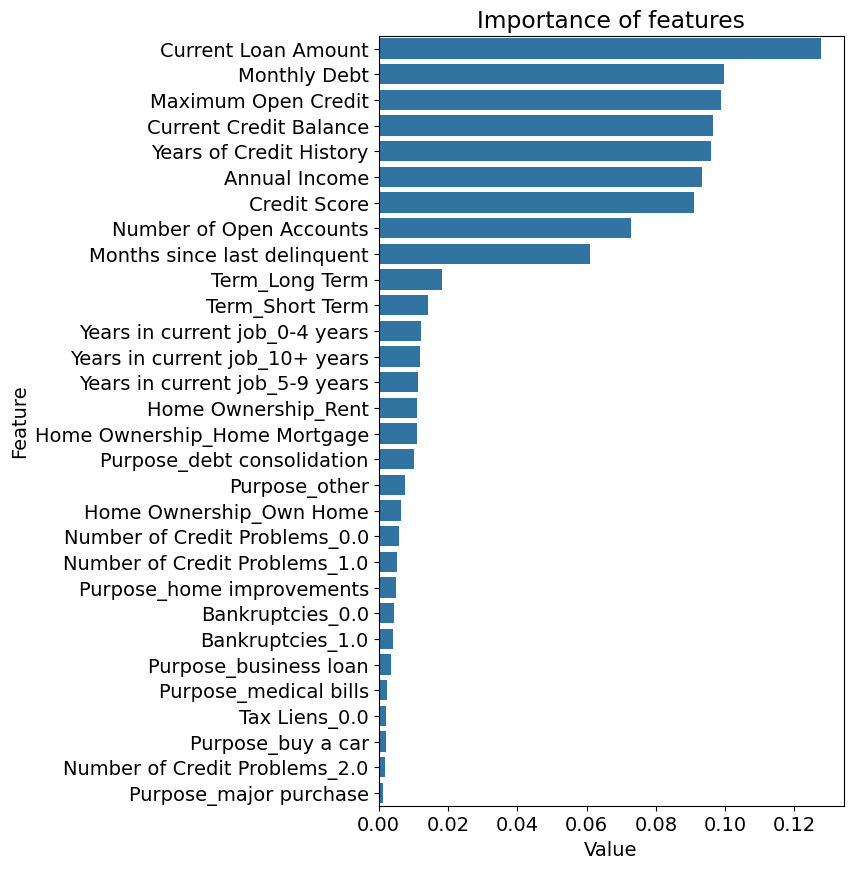

In [114]:
feature_importances = pd.DataFrame(sorted(zip(final_model.feature_importances_, X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize = (6, 10))
sns.barplot(x="Value", y="Feature", data=feature_importances.sort_values(by="Value", ascending=False).iloc[:30])
plt.title('Importance of features')

plt.show()

In [115]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=30) 
important_features_top

['Current Loan Amount',
 'Monthly Debt',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Years of Credit History',
 'Annual Income',
 'Credit Score',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Term_Long Term',
 'Term_Short Term',
 'Years in current job_0-4 years',
 'Years in current job_10+ years',
 'Years in current job_5-9 years',
 'Home Ownership_Rent',
 'Home Ownership_Home Mortgage',
 'Purpose_debt consolidation',
 'Purpose_other',
 'Home Ownership_Own Home',
 'Number of Credit Problems_0.0',
 'Number of Credit Problems_1.0',
 'Purpose_home improvements',
 'Bankruptcies_0.0',
 'Bankruptcies_1.0',
 'Purpose_business loan',
 'Purpose_medical bills',
 'Tax Liens_0.0',
 'Purpose_buy a car',
 'Number of Credit Problems_2.0',
 'Purpose_major purchase']

### Финальная модель

In [116]:
final_model = RandomForestClassifier(random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4297
           1       1.00      1.00      1.00      3393

    accuracy                           1.00      7690
   macro avg       1.00      1.00      1.00      7690
weighted avg       1.00      1.00      1.00      7690


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1090
           1       0.81      0.87      0.84       833

    accuracy                           0.85      1923
   macro avg       0.85      0.86      0.85      1923
weighted avg       0.86      0.85      0.85      1923



### Сохранение финальной модели

In [117]:
predictions = final_model.predict(df_test[important_features_top])
predictions.shape

(2500,)

In [118]:
output = pd.DataFrame({'Credit Default': predictions }) 
output.to_csv('Popova_predictions.csv', index=False)